<a href="https://colab.research.google.com/github/njericha/masters-thesis/blob/main/Neural_Network_Vocal_Separator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Scientific Python
import numpy as np
import numpy.matlib as matlib
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Music Sourse Seperation Dataset and Tools
get_ipython().system('pip install scaper')
get_ipython().system('pip install nussl')
get_ipython().system('pip install git+https://github.com/source-separation/tutorial')
import nussl
from nussl.datasets import transforms as nussl_tfm
import scaper
from common import utils, viz, data #sublibrary from source-separation/tutorial
from pathlib import Path

# Set up PyTorch
torch.set_default_dtype(torch.float64)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Run on", device)

# Set Seed for Random Process
seed = 2022
np.random.seed(seed)
nussl.utils.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

     |████████████████████████████████| 3.3 MB 6.2 MB/s 
     |████████████████████████████████| 51 kB 62 kB/s 
     |████████████████████████████████| 90 kB 6.6 MB/s 
  Created wheel for jams: filename=jams-0.3.4-py3-none-any.whl size=64922 sha256=c2cce62472360ec90f290dad9f65d884b66bd429ec3f52e153135b6768421ec7
  Stored in directory: /root/.cache/pip/wheels/c9/aa/16/ce72bc4caa58dfab819e3f46b3542f2bf90a83009f4ea07a48
  Created wheel for mir-eval: filename=mir_eval-0.7-py3-none-any.whl size=100721 sha256=649b2c9244feb17e2759d397ebcb6340a04a2cfefd63ce4612ab93b2424d6737
  Stored in directory: /root/.cache/pip/wheels/18/5a/46/d2527ff1fd975e1a793375e6ed763bfe4d3ea396b7cdc470eb
Successfully built jams mir-eval
     |████████████████████████████████| 239 kB 5.3 MB/s 
     |████████████████████████████████| 310 kB 41.0 MB/s 
     |████████████████████████████████| 251 kB 41.5 MB/s 
     |████████████████████████████████| 153 kB 45.8 MB/s 
     |████████████████████████████████| 963 kB 42.4 MB/

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


Run on cuda


In [ ]:
# wrappers to quickly convert between numpy and pytorch
to_numpy  = lambda x: x.detach().numpy()
to_tensor = lambda x: torch.from_numpy(x).float()

In [ ]:
# plotting parameters
sns.set()
sns.set_context('paper',rc={"font.size": 18})
sns.set_style('whitegrid', {'axes.linewidth': 2.0,'axes.grid': False})
matplotlib.rcParams['figure.dpi'] = 150 #resolution for figures
matplotlib.rcParams["image.cmap"] = 'viridis'
figscale = 0.5
experiment_name = 'nn'

In [ ]:
##---Dataset Parameters---##
# Parameters for loading the data
max_mixtures = 1000 # Generates song clips "on the fly"
batch_size   = 20
train_coherent_prob = 1.0 # 1 = sources in a mixture are from same song, 0 = sources from different songs
valid_coherent_prob = 1.0 # this may be desired in training to generalize better
content_folder = '/content' # where to store the dataset
song_length  = 2 #seconds
sample_rate  = 44100 // 4 #Hz

# Data parameters for training the model and preprocessing
whiten_data = False # normalize data in the frequency dimention
normalize   = True  # rescales spectrogram so peak magnitude is 1
use_log     = False # preprocess data with log-spectrogram
noise_floor = -7    # what a zero magnitude gets mapped to in log scale, avoids -inf when taking log
shuffle     = True  # batches use different songs after each epoch
stretch_power = 0.5 # raises elements of the spectrogram to this power
num_workers = 0     # how many subprocesses to use for data loading
eps = 1e-8          # small value to avoid errors when dividing a spectrogram with values close to 0

#STFT
window_length = 512 # Number of frequency bins in STFT
hop_length    = 128 # Number of time bins in STFT
window_type   = 'sqrt_hann' # blackman, hamming, triang, hann, exponential, sqrt_hann

In [ ]:
# Download and Prepare Music Database (MUSDB18)
data.prepare_musdb(content_folder) # assume mono sourses

Done!


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


In [ ]:
# Code from https://source-separation.github.io/tutorial

utils.logger()

stft_params = nussl.STFTParams(window_length=window_length, hop_length=hop_length, window_type=window_type)

tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]), # uncomment to sum backgrounds together as a single source
    nussl_tfm.MagnitudeSpectrumApproximation(), # Calculates the magnitude spectrograms of each source + mixture
    #nussl_tfm.IndexSources('source_magnitudes', 1), # converts keys of sources from an index (0=bass, 1=drums, 2=other, 3=vocals)
    nussl_tfm.ToSeparationModel() # ensures everything can be passed to a torch network
])

train_folder = content_folder + "/train"
val_folder   = content_folder + "/valid"

train_data = data.on_the_fly(stft_params, transform=tfm, fg_path=train_folder, num_mixtures=max_mixtures, coherent_prob=train_coherent_prob, duration=song_length, sample_rate=sample_rate)
train_dataloader = DataLoader(train_data, num_workers=num_workers, batch_size=batch_size,shuffle=shuffle)

val_data = data.on_the_fly(stft_params, transform=tfm, fg_path=val_folder, num_mixtures=max_mixtures, coherent_prob=valid_coherent_prob, duration=song_length, sample_rate=sample_rate)
val_dataloader = DataLoader(val_data, num_workers=num_workers, batch_size=batch_size,shuffle=shuffle)

#nf = stft_params.window_length // 2 + 1 #number of features?
song_0 = train_data[0]
n_hops, n_frqs, n_channels, n_sources = np.shape(song_0['source_magnitudes'])

In [ ]:
frqs_list = np.linspace(0.0, sample_rate // 2,num=n_frqs)
hops_list = np.linspace(0.0, song_length ,num=n_hops)
print(n_hops, n_frqs, n_channels, n_sources)

174 257 1 2


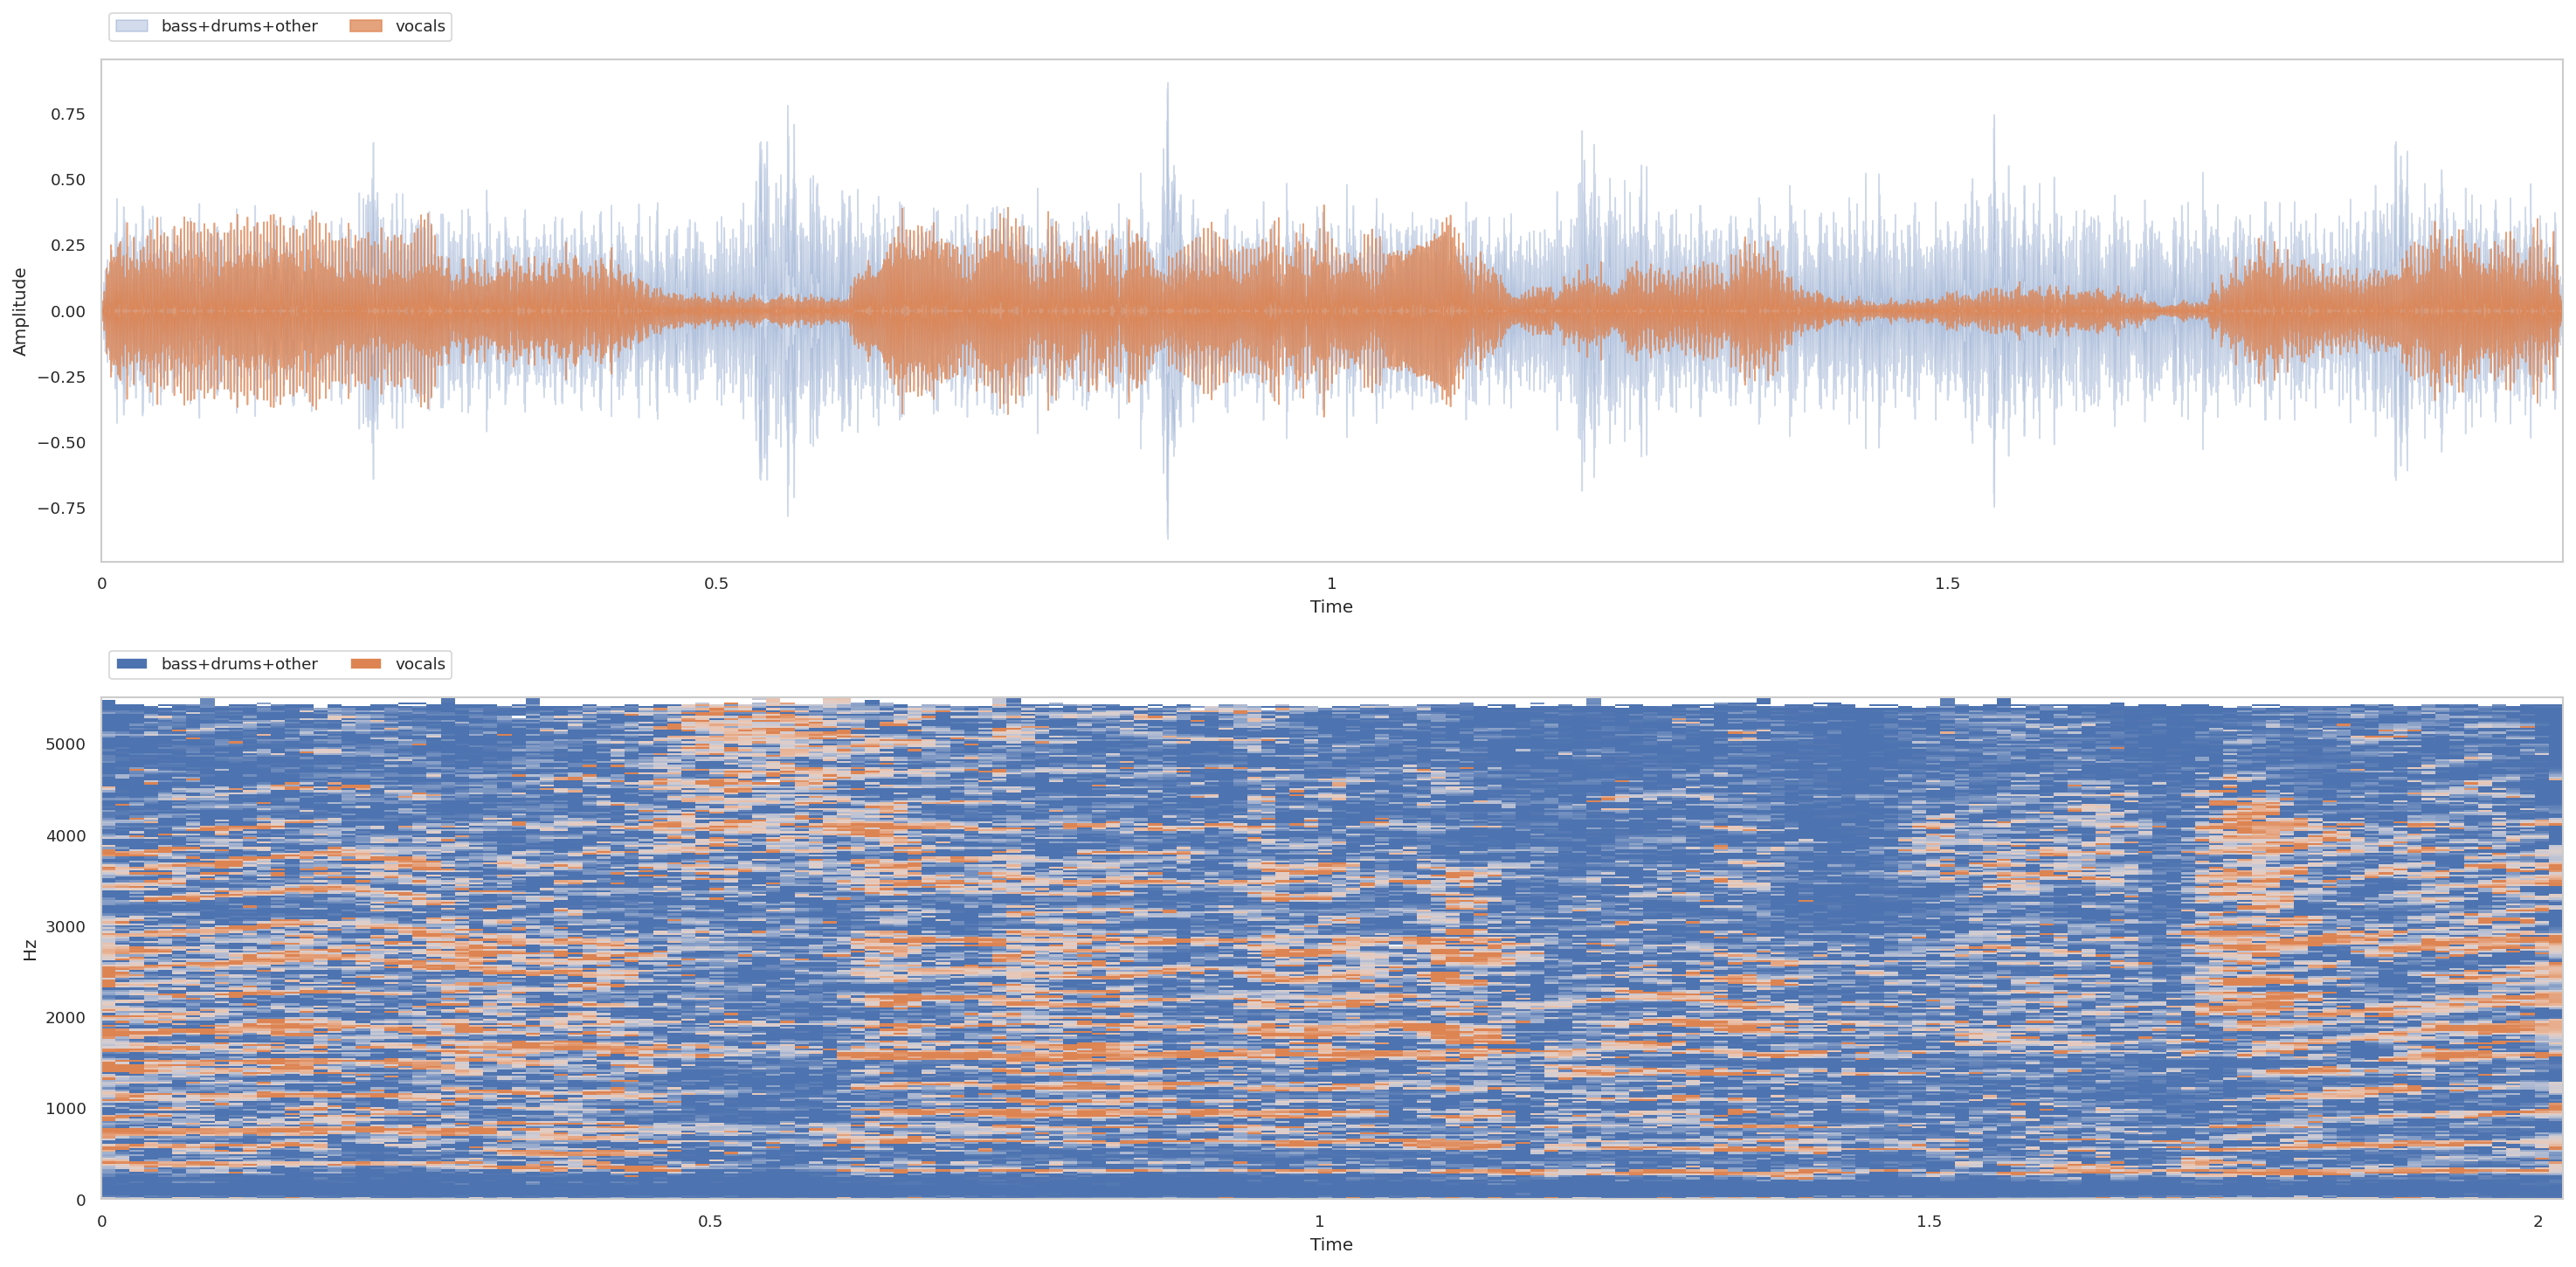


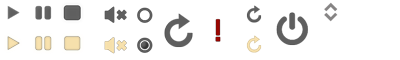
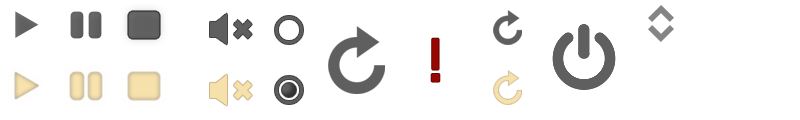
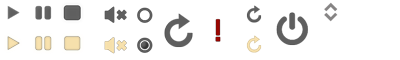

In [ ]:
##---Generate A Sample & Make Sure Everything has Loaded Correctly---##
sample_data = data.on_the_fly(stft_params, transform=nussl_tfm.Compose([nussl_tfm.SumSources([['bass', 'drums', 'other']])]),
                              fg_path=train_folder, num_mixtures=1, coherent_prob=1.0, duration=song_length, sample_rate=sample_rate)
sample_song = sample_data[0]
viz.show_sources(sample_song['sources'])

In [ ]:
N_train = len(train_data)
N_valid = len(val_data)
N_train_batch = len(train_dataloader)
N_valid_batch = len(val_dataloader)
print("Total Training and Validation size:", (N_train,N_valid))
print("Batch Training and Validation size:", (N_train_batch,N_valid_batch))

n_batches = max_mixtures // batch_size

Total Training and Validation size: (1000, 1000)
Batch Training and Validation size: (50, 50)


In [ ]:
##--Pre Load Dataset--##
# data.on_the_fly() generates mixtures as they are needed. This helps save memory,
# but it may be desirable to load all the data if enough memory is avalible for
# faster training. Takes about a minute on GPU for 600 songs
# Works for medium sized data sets, too large and the GPU does not have enough memory
pre_load = True

if whiten_data: #check this
    #batch = train_data[:50] # look at the first 50 songs in data set 50*[time, frequency, channel]
    avg_val_per_frq = torch.mean(train_data['mix_magnitude'],dim=(0,2)) # average frequency value over all other dimentions
    avg_val_per_frq_viewed = avg_val_per_frq.view(1,-1,1)

def whiten_spectrogram(x):
    '''Scales spectrograms in the frequency dimention so the average magnitude
    across the data is one. For example, high frequencies are often quiter than
    low frequencies in musical recordings, so this puts both ranges on equal footing.'''
    return x / avg_val_per_frq_viewed

def log_spectrogram(x,noise_floor=noise_floor):
    '''Wrapper to convert to a log-power spectrogram'''
    x = torch.log10(x)
    #noise_floor = torch.min(x[x != -torch.inf])
    #x[x == -torch.inf] = noise_floor #avoids -inf in log-space for STFT values close to zero
    #x[x == -torch.inf] = noise_floor 
    x[x < noise_floor] = noise_floor
    x = x - noise_floor #set the reference dB to -noise_floor, ensures only positive values
    return x

def stretch_spectrogram(x,stretch_power=stretch_power):
    '''Stretches the spectrogram by stretch_power'''
    return torch.pow(x,stretch_power)

def normalize_spectrogram(x):
    '''Given an input, divide by the largest value (in the last two dimentions).
    Assumes x has all positive values.'''
    return x / torch.max(x) #(torch.max( torch.max(x, dim=2, keepdim=True)[0],dim=1,keepdim=True)[0])

def pre_process(x):
    '''Performs the preprocessing steps as long as their condition is satisfied'''
    x = whiten_spectrogram(x)    if whiten_data else x
    x = log_spectrogram(x)       if use_log else x
    x = normalize_spectrogram(x) if normalize else x
    x = stretch_spectrogram(x)   if stretch_power != 1 else x #will stay normalized since 1^stretch_power == 1
    return x

def make_data(song,device=device):
    '''Takes a song with magnitude spectrums and preprocesses it to a data point
    for pytorch'''
    inputs = song['mix_magnitude']
    inputs = inputs.permute(2, 1, 0) # permute from nussl's format of [time, frequency, channels]
                                     #           to torch's format of [channels, frequency, time]
    outputs = song['source_magnitudes']
    outputs = outputs.permute(2, 1, 0, 3)
    outputs_vocals = outputs[:,:,:,1]
    outputs_accomp = outputs[:,:,:,0]

    ideal_vocal_mask  = np.clip(outputs_vocals / (inputs + eps),eps,1) #Need clip since the model can only learn mask values between 0 and 1
    ideal_accomp_mask = np.clip(outputs_accomp / (inputs + eps),eps,1) #Alternativly use 1 - ideal_vocal_mask

    inputs = pre_process(inputs)
    outputs_vocals = ideal_vocal_mask  * inputs #pre_process(outputs_vocals)
    outputs_accomp = ideal_accomp_mask * inputs #pre_process(outputs_accomp)

    data = torch.stack([inputs,outputs_vocals,outputs_accomp])
    return data.to(device)

if pre_load:
    # Main loop to go through each imported song and preprocess it to a data point for PyTorch
    pre_loaded_train = [make_data(song_train) for song_train in train_data]
    pre_loaded_valid = [make_data(song_valid) for song_valid in val_data  ]
    # create dataloaders
    train_dataloader = DataLoader(pre_loaded_train,num_workers=num_workers,batch_size=batch_size,shuffle=shuffle)
    val_dataloader   = DataLoader(pre_loaded_valid,num_workers=num_workers,batch_size=batch_size,shuffle=shuffle)
            
else:
    #train_dataloader = DataLoader(pre_loaded_train,num_workers=num_workers,batch_size=batch_size,shuffle=shuffle,pin_memory=True)
    #val_dataloader   = DataLoader(pre_loaded_valid,num_workers=num_workers,batch_size=batch_size,shuffle=shuffle,pin_memory=True)
    pass
    #train_data, valid_data = train_dataloader, val_dataloader

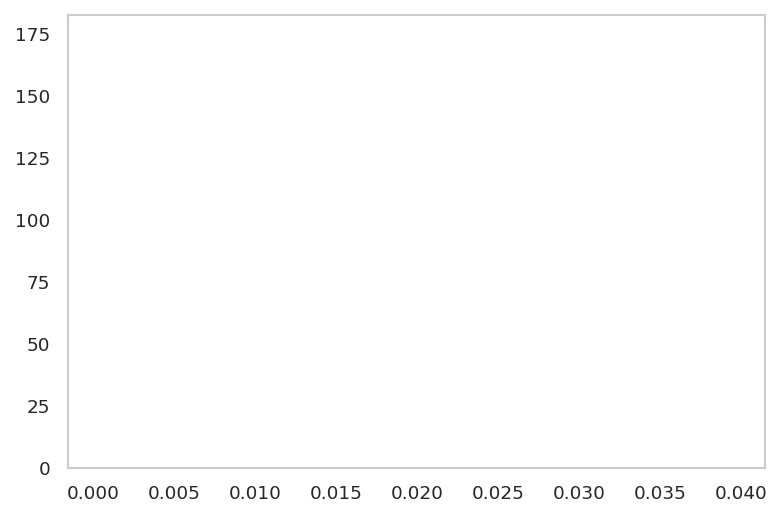

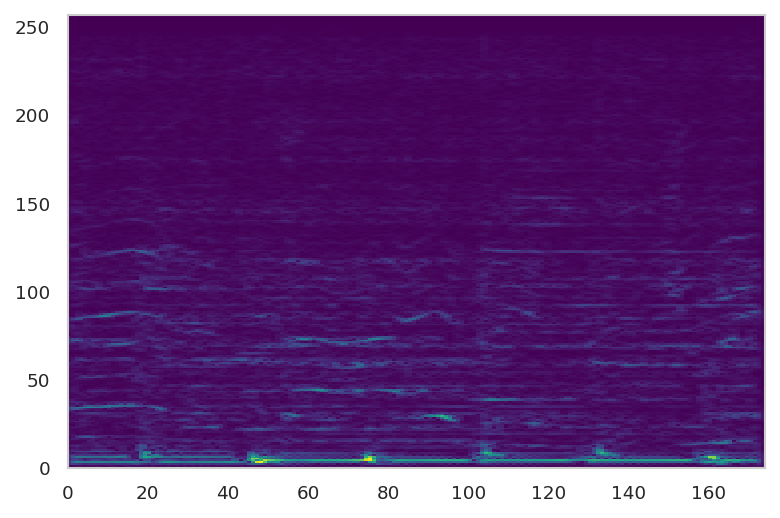

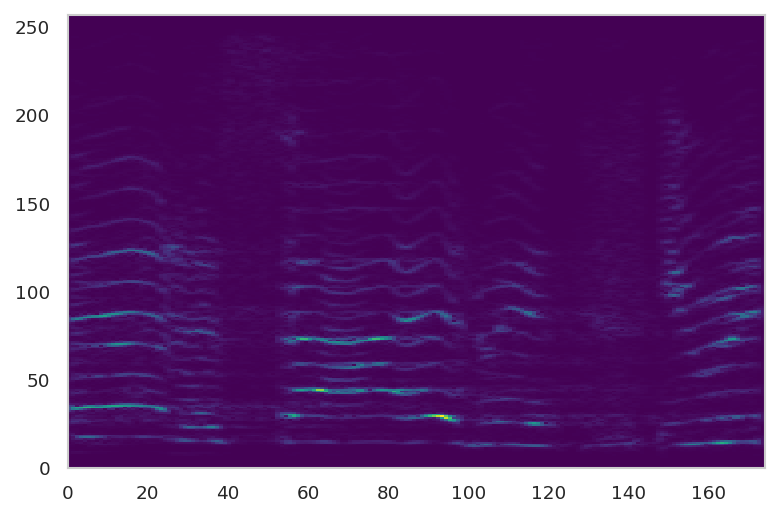

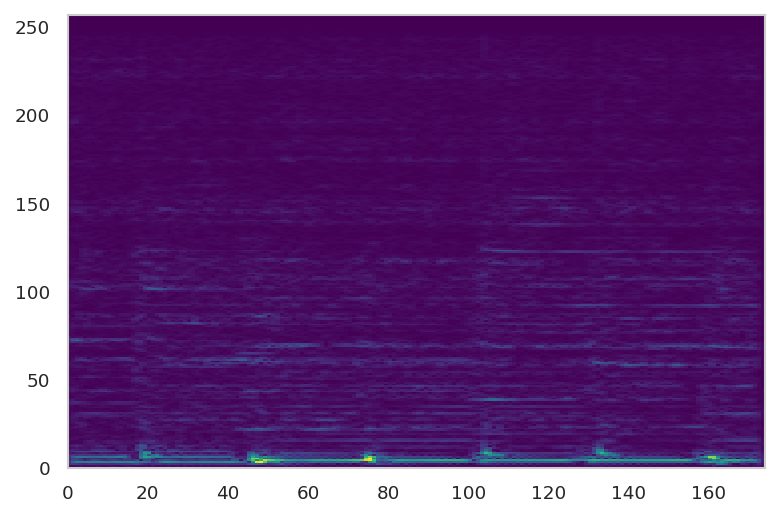

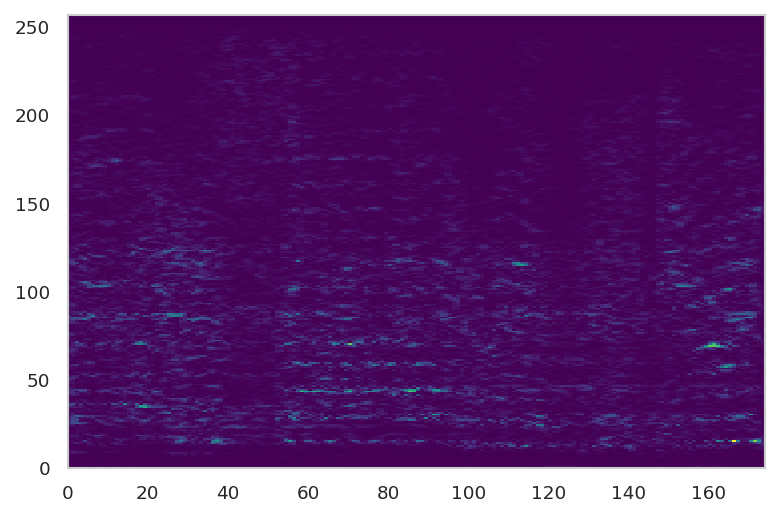

In [ ]:
## BEFORE PREPROCESSING
song = train_data[0]
inputs = song['mix_magnitude']
inputs = inputs.permute(2, 1, 0) # permute from nussl's format of [time, frequency, channels]
                                    #           to torch's format of [channels, frequency, time]
outputs = song['source_magnitudes']
outputs = outputs.permute(2, 1, 0, 3)
outputs_vocals = outputs[:,:,:,1]
outputs_accomp = outputs[:,:,:,0]

# Plot to make sure things are working
plt.figure(0)
plt.hist(outputs_accomp[0]+outputs_vocals[0]-inputs[0]) #expect most points to be near zero
plt.figure(1)
plt.pcolor(inputs[0])
plt.figure(2)
plt.pcolor(outputs_vocals[0])
plt.figure(3)
plt.pcolor(outputs_accomp[0])
plt.figure(4)
plt.pcolor(outputs_accomp[0]+outputs_vocals[0]-inputs[0])

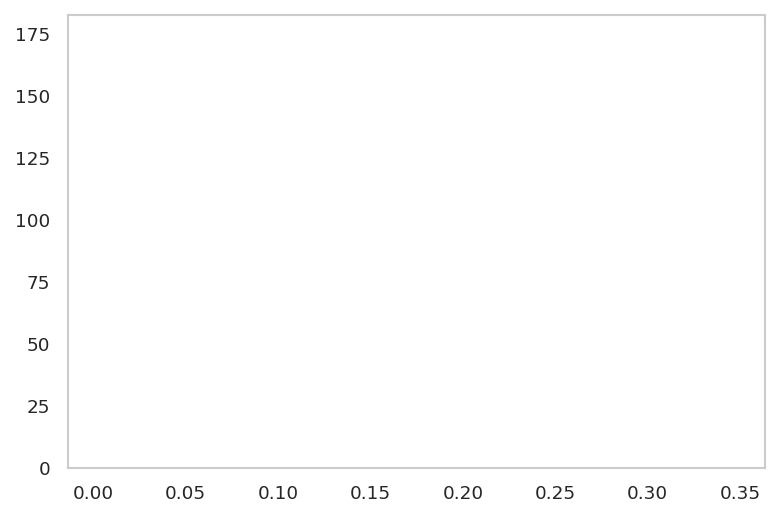

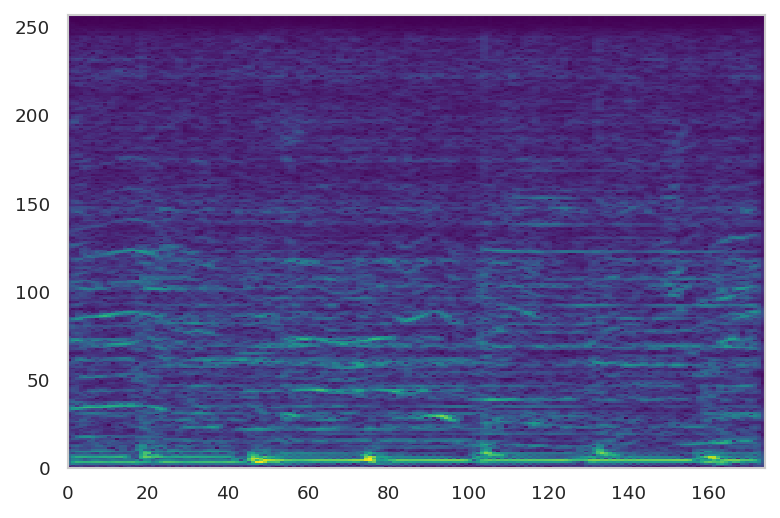

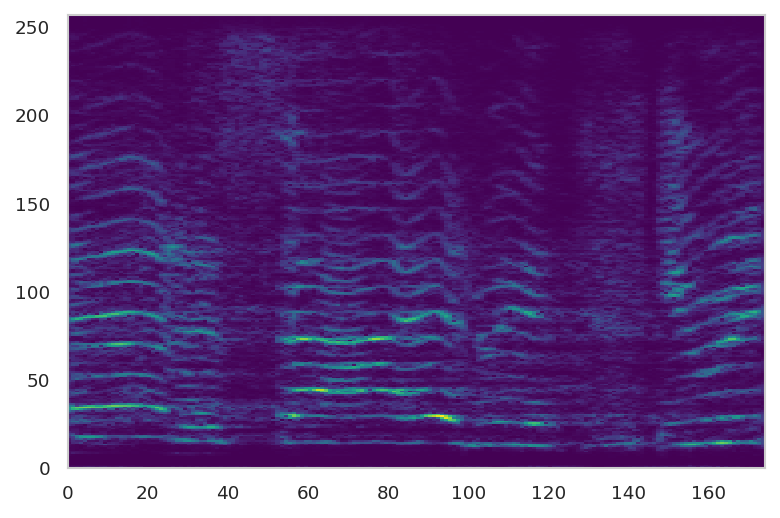

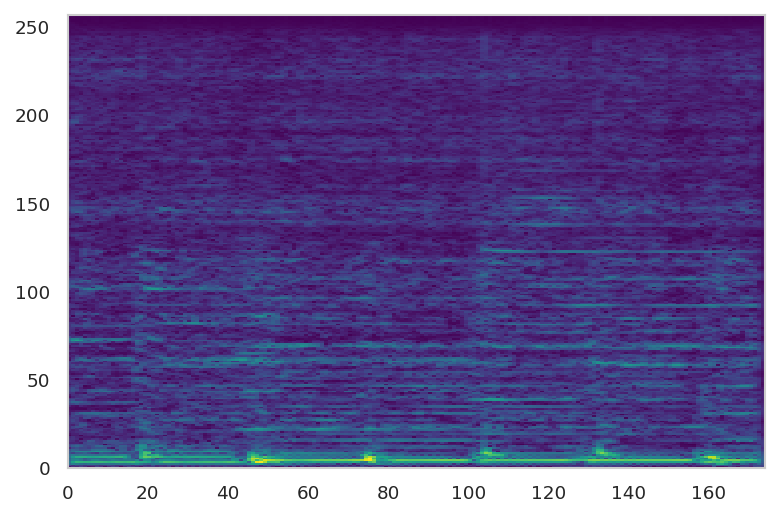

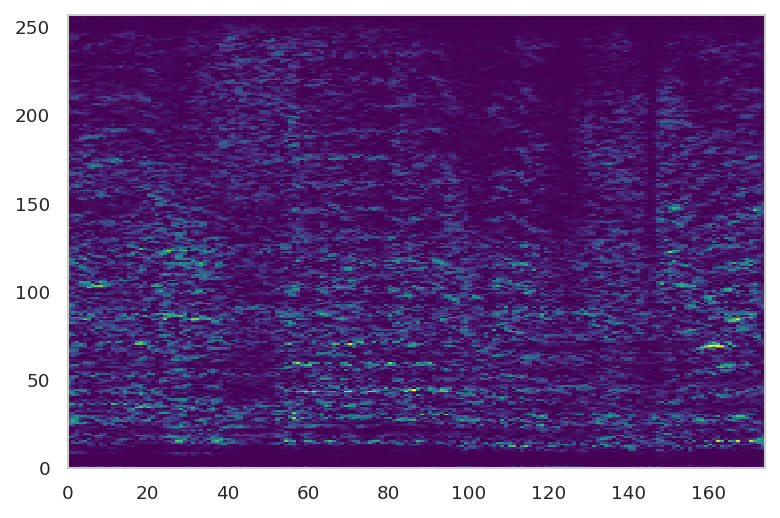

In [ ]:
## AFTER PREPROCESSING
train_data = pre_loaded_train[0].to('cpu')
# Unpack data for visualization
inputs         = train_data[0,:,:,:]
outputs_vocals = train_data[1,:,:,:]
outputs_accomp = train_data[2,:,:,:]

# Plot to make sure things are working
plt.figure(0)
plt.hist(outputs_accomp[0]+outputs_vocals[0]-inputs[0]) #expect most points to be near zero
plt.figure(1)
plt.pcolor(inputs[0])
plt.figure(2)
plt.pcolor(outputs_vocals[0])
plt.figure(3)
plt.pcolor(outputs_accomp[0])
plt.figure(4)
plt.pcolor(outputs_accomp[0]+outputs_vocals[0]-inputs[0])

(array([[ 67., 101.,   6., ...,   0.,   0.,   0.],
        [  8., 119.,  46., ...,   0.,   0.,   0.],
        [  2.,  17.,  57., ...,   0.,   0.,   0.],
        ...,
        [174.,   0.,   0., ...,   0.,   0.,   0.],
        [174.,   0.,   0., ...,   0.,   0.,   0.],
        [174.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([0.00102325, 0.10092093, 0.2008186 , 0.30071628, 0.40061395,
        0.50051163, 0.6004093 , 0.70030698, 0.80020465, 0.90010233,
        1.        ]),
 <a list of 257 Lists of Patches objects>)

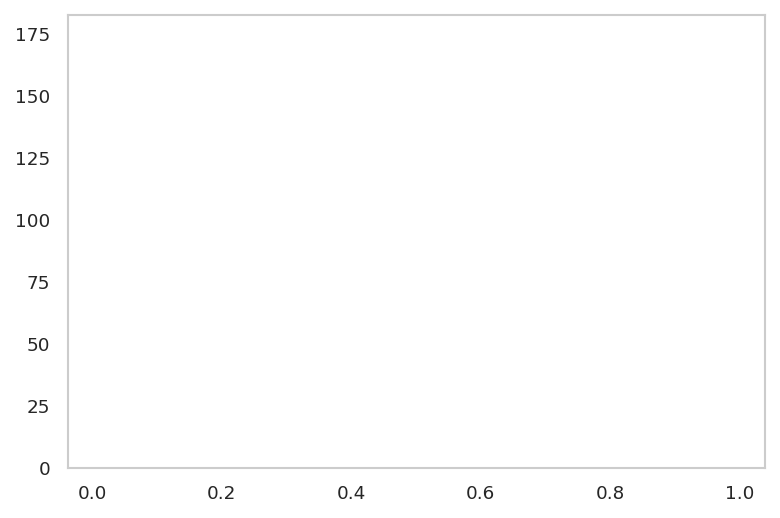

In [ ]:
plt.hist(inputs[0])

In [ ]:
class myNet(nn.Module):
    def __init__(self, k_size1, k_size2, t_stride, H, L):
        super(myNet, self).__init__()
        # Shape and size handeling
        self.k_size1 = k_size1 #n_frqs
        self.k_size2 = k_size2 #4
        self.t_stride = t_stride
        self.input_shape      = (1, n_frqs               , n_hops               ) #TODO change 1 to n_channels incase input is not mono
        self.layer1_out_shape = (H, n_frqs-self.k_size1+1, n_hops               )
        self.layer2_out_shape = (H, n_frqs-self.k_size1+1, (n_hops-self.k_size2)//t_stride +1)
        self.layer3_in_size   = np.prod(self.layer2_out_shape)
        self.layer3_out_size  = L
        #self.layer4_out_size  = n_frqs*n_hops # * n_sources if more sources than just vocal-other seperation
        
        # Feedforward layers
        self.layer1 = nn.Conv2d(in_channels=1, out_channels=H, kernel_size=(self.k_size1,1))
        self.layer2 = nn.Conv2d(in_channels=H, out_channels=H, kernel_size=(1,self.k_size2),stride=(1,self.t_stride))
        self.layer3 = nn.Linear(self.layer3_in_size, self.layer3_out_size)
        self.layer4 = nn.Linear(self.layer3_out_size, self.layer3_in_size)
        self.layer5 = nn.ConvTranspose2d(in_channels=H, out_channels=H, kernel_size=(1,self.k_size2),stride=(1,self.t_stride))
        self.layer6 = nn.ConvTranspose2d(in_channels=H, out_channels=1, kernel_size=(self.k_size1,1))

        # Batch Normalization
        self.batchnorm0 = nn.BatchNorm2d(n_channels)
        self.batchnorm1 = nn.BatchNorm2d(H)
        self.batchnorm2 = nn.BatchNorm2d(H)
        self.batchnorm3 = nn.BatchNorm1d(self.layer3_out_size)
        #self.batchnorm4 = nn.BatchNorm1d(self.layer3_in_size)
        self.batchnorm4 = nn.BatchNorm2d(H)
        self.batchnorm5 = nn.BatchNorm2d(H)
        self.batchnorm6 = nn.BatchNorm2d(n_channels)

        # dropout layer
        #self.dropout4   = nn.Dropout(p=0.5)
        self.activation = nn.Tanh() #add this

    def forward(self, x):
        batch_size = x.shape[0]
        #x0 = self.batchnorm0(x) #may not be needed if more preprocessing to normalize data is performed

        x1 = self.layer1(x)
        x1_bn = self.batchnorm1(x1)
        x1_tanh = self.activation(x1_bn)

        x2 = self.layer2(x1_tanh)
        x2_bn = self.batchnorm2(x2)
        x2_tanh = self.activation(x2_bn)
        x2_tanh = x2_tanh.reshape(batch_size,self.layer3_in_size) #flatten to a vector that nn.Linear can accept
        
        x3 = self.layer3(x2_tanh)
        x3_bn = self.batchnorm3(x3)
        x3_tanh = self.activation(x3_bn)
        
        x4 = self.layer4(x3_tanh)
        x4 = x4.reshape(batch_size,*self.layer2_out_shape) #reshape vector back to matrix
        x4 += x2 #inner skip connection
        x4_bn = self.batchnorm4(x4)
        x4_tanh = self.activation(x4_bn)
        #x4_drop = self.dropout4(x4_tanh) #dropout on decoder layers before the second to last layer
        
        x5 = self.layer5(x4_tanh)
        x5 += x1 #outer skip connection
        x5_bn = self.batchnorm5(x5)
        x5_tanh = self.activation(x5_bn)
        
        x6 = self.layer6(x5_tanh)
        x6_bn = x6#self.batchnorm6(x6) #shouldn't have it? since this is the end of network and sigmoid is just to get a value between (0,1)
        y_pred  = x6_bn.sigmoid()

        y_mask_vocals = y_pred #y_pred.reshape(batch_size,n_channels,n_frqs,n_hops)
        y_mask_accomp = 1 - y_mask_vocals
        return y_mask_vocals, y_mask_accomp
    
def getweights(w, gamma = 2):
    weights = torch.norm(w, dim = 0).pow(gamma).data
    return weights

def proximal(w, lam, eta):
    tmp = torch.norm(w, dim = 0) - lam*eta
    alpha = torch.clamp(tmp, min = 0)
    v = nn.functional.normalize(w, dim = 0)*alpha[None,:]
    w.data = v

def hard_thres(w, thres_param):
    with torch.no_grad():
        w_norm = getweights(w) 
        w_norm[w_norm < thres_param] =0
        w_pos = np.nonzero(w_norm).squeeze(1)
        
        v = torch.zeros([L,H]).to(device) #TODO ensure this size is correct
        v[:, w_pos] = w[:,w_pos]
        w.data = v
         
def test(model, inputs, outputs, verbose = False):
    model.cpu()
    model.eval() # some layers behave differently during training and eval
    inputs = torch.from_numpy(inputs)
    outputs = torch.from_numpy(outputs)
    
    with torch.no_grad():
        y_pred = model(inputs)
        loss = torch.norm(y_pred-outputs)/torch.norm(outputs) # y_pred and outputs are of size (N_test,)
    return loss

def print_loss(loss_type,total,vocals,accomp):
    print(loss_type)
    print(f'Vocals Loss: {vocals:.2%}', f'Accomp Loss: {accomp:.2%}')
    print(f'Weighted Loss: {total:.2%}')
    print('')

# \sqrt({\sum_{j} ||y_{pred,j} - y_{true,j}||^2) /\sqrt{\sum_{j} ||y_{true,j}||^2}}

# \sum_{j} ||y_{pred,j} - y_{true,j}||^2 / N_test - MSE loss

In [ ]:
##-------------- Parameters of Neural Network ---------------##
sigmaRun = 0
iterMax = 1
n_sources = 2 #vocals, accompaniment
k_size1, k_size2 = n_frqs, 4 # kernel size for the first layer in frequency dimention, second layer in time dimention
t_stride = 1 #stride in the time dimention for the second convolution layer
H = 64  # Number of hidden channels in convolution layers
L = 16 # Number of nodes in the latent space
eta = 5e-4 # Learning Rate for Adam in the pretrained weight step and for SGD in the adaptive step #1e-3 defult
SGDrate = 2e-2
epochMax = 100 #25
thres_param = 1e-4
loss_vocals_weight = 0.5
loss_accomp_weight = 0.5
reg_adaptive_lasso = 64.0

In [ ]:
#---Loss Functions---#
#criterion = nn.MSELoss(reduction ='mean')
#criterion = lambda y_pred, y: torch.norm(y - y_pred)/torch.norm(y) # relative error loss
#criterion = lambda y_pred, y: torch.norm((y - y_pred)/y) # relative error loss
#criterion = nussl.ml.train.loss.L1Loss()
#criterion = nn.L1Loss()
# Average (over all songs in a batch, and over all channels) of relative squared error
#criterion = lambda y_pred, y: torch.mean( torch.norm(y-y_pred,dim=(2,3))/torch.norm(y,dim=(2,3)) )

criterion = lambda y_pred, y: torch.mean( torch.square(torch.norm(y-y_pred,dim=(2,3))/torch.norm(y,dim=(2,3)) )) #squared average relative error

#criterion = lambda y_pred, y: torch.mean( torch.square(torch.norm((y-y_pred),dim=(2,3)) ))
#criterion = lambda y_pred, y: torch.mean( torch.norm(y-y_pred,p=1,dim=(2,3))/torch.norm(y,p=1,dim=(2,3)) ) #L1,1 norm
#criterion = lambda y_pred, y: torch.mean( torch.norm(y-y_pred,dim=(2,3))/(n_frqs*n_hops) )

loss_f = lambda vocals, accomp: loss_vocals_weight*vocals + loss_accomp_weight*accomp

In [ ]:
#reg_adaptive_lasso_vec = [0.01, 0.02,0.05, 0.1, 0.2, 0.4]
verbose = False
#verbose_figure = True
retrain = False # retrains the network with group sparsity
skip_pre_train = False
check_val_loss = 5 # performs validation step every n-steps

train_part1_loss = np.zeros(epochMax*n_batches)
val_part1_loss   = np.zeros(epochMax*n_batches//check_val_loss)
train_part2_loss = np.zeros(epochMax*n_batches)
val_part2_loss   = np.zeros(epochMax*n_batches//check_val_loss)

#keep track of which iteration the val loss was calculated
val_iterations   = np.arange(0,epochMax*n_batches,check_val_loss)

if not skip_pre_train:
    model1 = myNet(k_size1, k_size2, t_stride, H, L).to(device)
    optimizer_pretrained = optim.Adam(model1.parameters(), lr = eta) #optim.SGD(model1.parameters(), lr = eta)

    print(f"~~~Train 1~~~")
    #model1.train() #set to training mode
    for epoch in range(epochMax):
        print(f"--Epoch {epoch}--")
        for batch_num, (train_batch,val_batch) in enumerate(zip(train_dataloader,val_dataloader)):
            print(f"Batch: {batch_num} (Song Clips {batch_num*batch_size}-{(batch_num+1)*batch_size})")
            iteration_num = n_batches*epoch + batch_num
            #print(f'Iteration {iteration_num}')
            
            #---Training Step---#
                
            model1.train() #set back to training mode

            # Unpack data
            inputs         = train_batch[:,0,:,:,:]
            outputs_vocals = train_batch[:,1,:,:,:]
            outputs_accomp = train_batch[:,2,:,:,:]
            
            y_pred1_vocals_masks, y_pred1_accomp_masks = model1(inputs) #feedforward
            y_pred1_vocals = y_pred1_vocals_masks*inputs #apply masks
            y_pred1_accomp = y_pred1_accomp_masks*inputs

            loss_vocals = criterion(y_pred1_vocals,outputs_vocals)
            loss_accomp = criterion(y_pred1_accomp,outputs_accomp)
            loss1 = loss_f(loss_vocals,loss_accomp) # Take weighted average of both losses
            train_part1_loss[iteration_num] = loss1

            optimizer_pretrained.zero_grad()
            loss1.backward()
            optimizer_pretrained.step()
            
            if verbose: print_loss('Training',loss1,loss_vocals,loss_accomp)

            if iteration_num % check_val_loss == 0:
                #---Validation Step---#
                model1.eval()

                # Unpack data
                inputs         = val_batch[:,0,:,:,:]
                outputs_vocals = val_batch[:,1,:,:,:]
                outputs_accomp = val_batch[:,2,:,:,:]

                y_pred_vocals_masks, y_pred_accomp_masks = model1(inputs) #feedforward
                y_pred_vocals = y_pred_vocals_masks*inputs #apply masks
                y_pred_accomp = y_pred_accomp_masks*inputs

                loss_vocals = criterion(y_pred_vocals,outputs_vocals)
                loss_accomp = criterion(y_pred_accomp,outputs_accomp)
                loss_val = loss_f(loss_vocals,loss_accomp)
                val_part1_loss[iteration_num//check_val_loss] = loss_val

                if verbose: print_loss('Validate',loss_val,loss_vocals,loss_accomp)

##----Re-Training to Enforce Sparse Third Layer Weights----##
if retrain:

    preweights = 1/getweights(model1.layer4.weight) #Want only the third layer's weights
    model2 = myNet(k_size1, k_size2, t_stride, H, L).to(device)
    optimizer_adaptive = optim.SGD(model2.parameters(), lr = SGDrate) #optim.Adam(model2.parameters(), lr = eta)#

    print(f"~~~Train 2~~~")
    model2.train() #set to training mode
    for epoch in range(epochMax):
        print(f"--Epoch {epoch} (Train 2)--")
        for batch_num, (train_batch,val_batch) in enumerate(zip(train_dataloader,val_dataloader)):
            print(f"Batch: {batch_num} (Song Clips {batch_num*batch_size}-{(batch_num+1)*batch_size})")
            iteration_num = n_batches*epoch + batch_num
            
            #---Training Step---#

            # Unpack data
            inputs         = train_batch[:,0,:,:,:]
            outputs_vocals = train_batch[:,1,:,:,:]
            outputs_accomp = train_batch[:,2,:,:,:]
            
            y_pred2_vocals_masks, y_pred2_accomp_masks = model2(inputs) #feedforward
            y_pred2_vocals = y_pred2_vocals_masks*inputs #apply masks
            y_pred2_accomp = y_pred2_accomp_masks*inputs

            loss_vocals = criterion(y_pred2_vocals,outputs_vocals)
            loss_accomp = criterion(y_pred2_accomp,outputs_accomp)
            loss2 = loss_f(loss_vocals,loss_accomp)
            train_part2_loss[iteration_num] = loss2

            optimizer_adaptive.zero_grad()
            loss2.backward()
            optimizer_adaptive.step()
            proximal(model2.layer4.weight, reg_adaptive_lasso*preweights, SGDrate) #fourth layer weights

            if verbose: print_loss('Training',loss2,loss_vocals,loss_accomp)

            if iteration_num % check_val_loss == 0:
                #---Validation Step---#
                model2.eval()

                # Unpack data
                inputs         = val_batch[:,0,:,:,:]
                outputs_vocals = val_batch[:,1,:,:,:]
                outputs_accomp = val_batch[:,2,:,:,:]

                y_pred_vocals_masks, y_pred_accomp_masks = model2(inputs) #feedforward
                y_pred_vocals = y_pred2_vocals_masks*inputs #apply masks
                y_pred_accomp = y_pred2_accomp_masks*inputs

                loss_vocals = criterion(y_pred_vocals,outputs_vocals)
                loss_accomp = criterion(y_pred_accomp,outputs_accomp)
                loss_val = loss_f(loss_vocals,loss_accomp)
                val_part2_loss[iteration_num//check_val_loss] = loss_val

                if verbose: print_loss('Validate',loss_val,loss_vocals,loss_accomp)

                model2.train() #set back training mode

    #hard_thres(model2.linear3.weight, thres_param) # Do I need to do this?
#TODO add testing step
#ideal_vocals_mask = torch.clip(outputs_vocals / (inputs + eps),eps,1)
#ideal_accomp_mask = torch.clip(outputs_accomp / (inputs + eps),eps,1)

Streaming output truncated to the last 5000 lines.
Batch: 48 (Song Clips 960-980)
Batch: 49 (Song Clips 980-1000)
--Epoch 2--
Batch: 0 (Song Clips 0-20)
Batch: 1 (Song Clips 20-40)
Batch: 2 (Song Clips 40-60)
Batch: 3 (Song Clips 60-80)
Batch: 4 (Song Clips 80-100)
Batch: 5 (Song Clips 100-120)
Batch: 6 (Song Clips 120-140)
Batch: 7 (Song Clips 140-160)
Batch: 8 (Song Clips 160-180)
Batch: 9 (Song Clips 180-200)
Batch: 10 (Song Clips 200-220)
Batch: 11 (Song Clips 220-240)
Batch: 12 (Song Clips 240-260)
Batch: 13 (Song Clips 260-280)
Batch: 14 (Song Clips 280-300)
Batch: 15 (Song Clips 300-320)
Batch: 16 (Song Clips 320-340)
Batch: 17 (Song Clips 340-360)
Batch: 18 (Song Clips 360-380)
Batch: 19 (Song Clips 380-400)
Batch: 20 (Song Clips 400-420)
Batch: 21 (Song Clips 420-440)
Batch: 22 (Song Clips 440-460)
Batch: 23 (Song Clips 460-480)
Batch: 24 (Song Clips 480-500)
Batch: 25 (Song Clips 500-520)
Batch: 26 (Song Clips 520-540)
Batch: 27 (Song Clips 540-560)
Batch: 28 (Song Clips 560-

In [ ]:
#x = model2.layer4
#y = preweights

#y = torch.norm(model2.layer4.weight.to('cpu'),dim=0)

In [ ]:
#model1.layer4.weight.to(device)

In [ ]:
#len(np.nonzero(y))/len(y)

In [ ]:
#plt.plot(to_numpy(y),'*')

In [ ]:
#plt.plot(to_numpy(y),'*')

In [ ]:
#1/preweights

In [ ]:
model_final = model1
model_final.cpu()
model_final.eval() #set to evaluate mode

myNet(
  (layer1): Conv2d(1, 64, kernel_size=(257, 1), stride=(1, 1))
  (layer2): Conv2d(64, 64, kernel_size=(1, 4), stride=(1, 1))
  (layer3): Linear(in_features=10944, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=10944, bias=True)
  (layer5): ConvTranspose2d(64, 64, kernel_size=(1, 4), stride=(1, 1))
  (layer6): ConvTranspose2d(64, 1, kernel_size=(257, 1), stride=(1, 1))
  (batchnorm0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm6): Ba

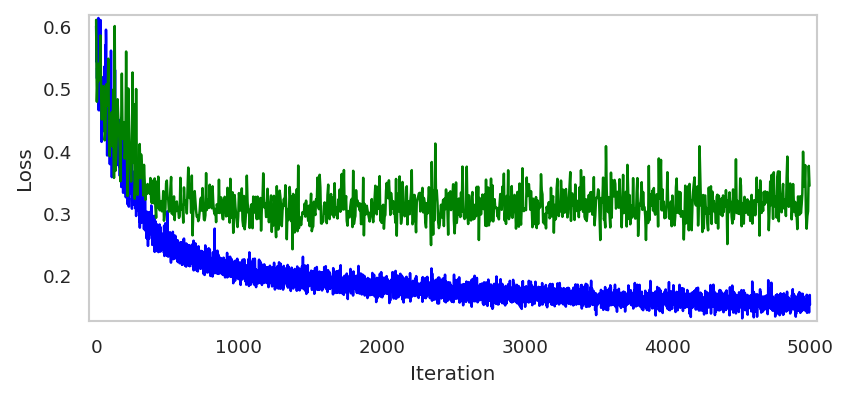

In [ ]:
#---Plot the results of training---#
plt.figure(figsize = (12*figscale,6*figscale))
plt.plot(train_part1_loss[:iteration_num+1],'blue',label = 'Training')# Part 1, ADAM')
#plt.plot(train_part2_loss[:iteration_num+1],'g',label = 'Training Part 2, ProxGD')
plt.plot(val_iterations[:iteration_num//check_val_loss+1],val_part1_loss[:iteration_num//check_val_loss+1],'green',label = 'Validation')# Part 1')
#plt.plot(val_iterations[:iteration_num//check_val_loss+1],val_part2_loss[:iteration_num//check_val_loss+1],'r',label = 'Validation Part 2')
plt.xlabel('Iteration')
plt.ylabel('Loss')
#plt.title('Training and Validation Losses')
#plt.legend()
plt.margins(0.01)
plt.tight_layout()
save_fp = f'/media/ex_{experiment_name}_loss.png'
plt.savefig(save_fp,format='png')

In [ ]:
#model_final = model2

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
total_n_weights = count_parameters(model_final)
print(f'Ratio of parameters to data: {total_n_weights / max_mixtures:.1f}')

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
|   layer1.weight   |   16448    |
|    layer1.bias    |     64     |
|   layer2.weight   |   16384    |
|    layer2.bias    |     64     |
|   layer3.weight   |   175104   |
|    layer3.bias    |     16     |
|   layer4.weight   |   175104   |
|    layer4.bias    |   10944    |
|   layer5.weight   |   16384    |
|    layer5.bias    |     64     |
|   layer6.weight   |   16448    |
|    layer6.bias    |     1      |
| batchnorm0.weight |     1      |
|  batchnorm0.bias  |     1      |
| batchnorm1.weight |     64     |
|  batchnorm1.bias  |     64     |
| batchnorm2.weight |     64     |
|  batchnorm2.bias  |     64     |
| batchnorm3.weight |     16     |
|  batchnorm3.bias  |     16     |
| batchnorm4.weight |     64     |
|  batchnorm4.bias  |     64     |
| batchnorm5.weight |     64     |
|  batchnorm5.bias  |     64     |
| batchnorm6.weight |     1      |
|  batchnorm6.bias  

In [ ]:
##-------EVALUATION ON TEST SET-----##
test_folder = content_folder + '/test'
tfm_test = tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]), # uncomment to sum backgrounds together as a single source
    nussl_tfm.MagnitudeSpectrumApproximation()#, # Calculates the magnitude spectrograms of each source + mixture
    #nussl_tfm.IndexSources('source_magnitudes', 1), # converts keys of sources from an index (0=bass, 1=drums, 2=other, 3=vocals)
    #nussl_tfm.ToSeparationModel() # ensures everything can be passed to a torch network
])
test_data = data.on_the_fly(stft_params, transform=tfm_test, fg_path=test_folder, num_mixtures=10, coherent_prob=1.0, duration=song_length, sample_rate=sample_rate)
test_dataloader = DataLoader(test_data, num_workers=1, batch_size=1)

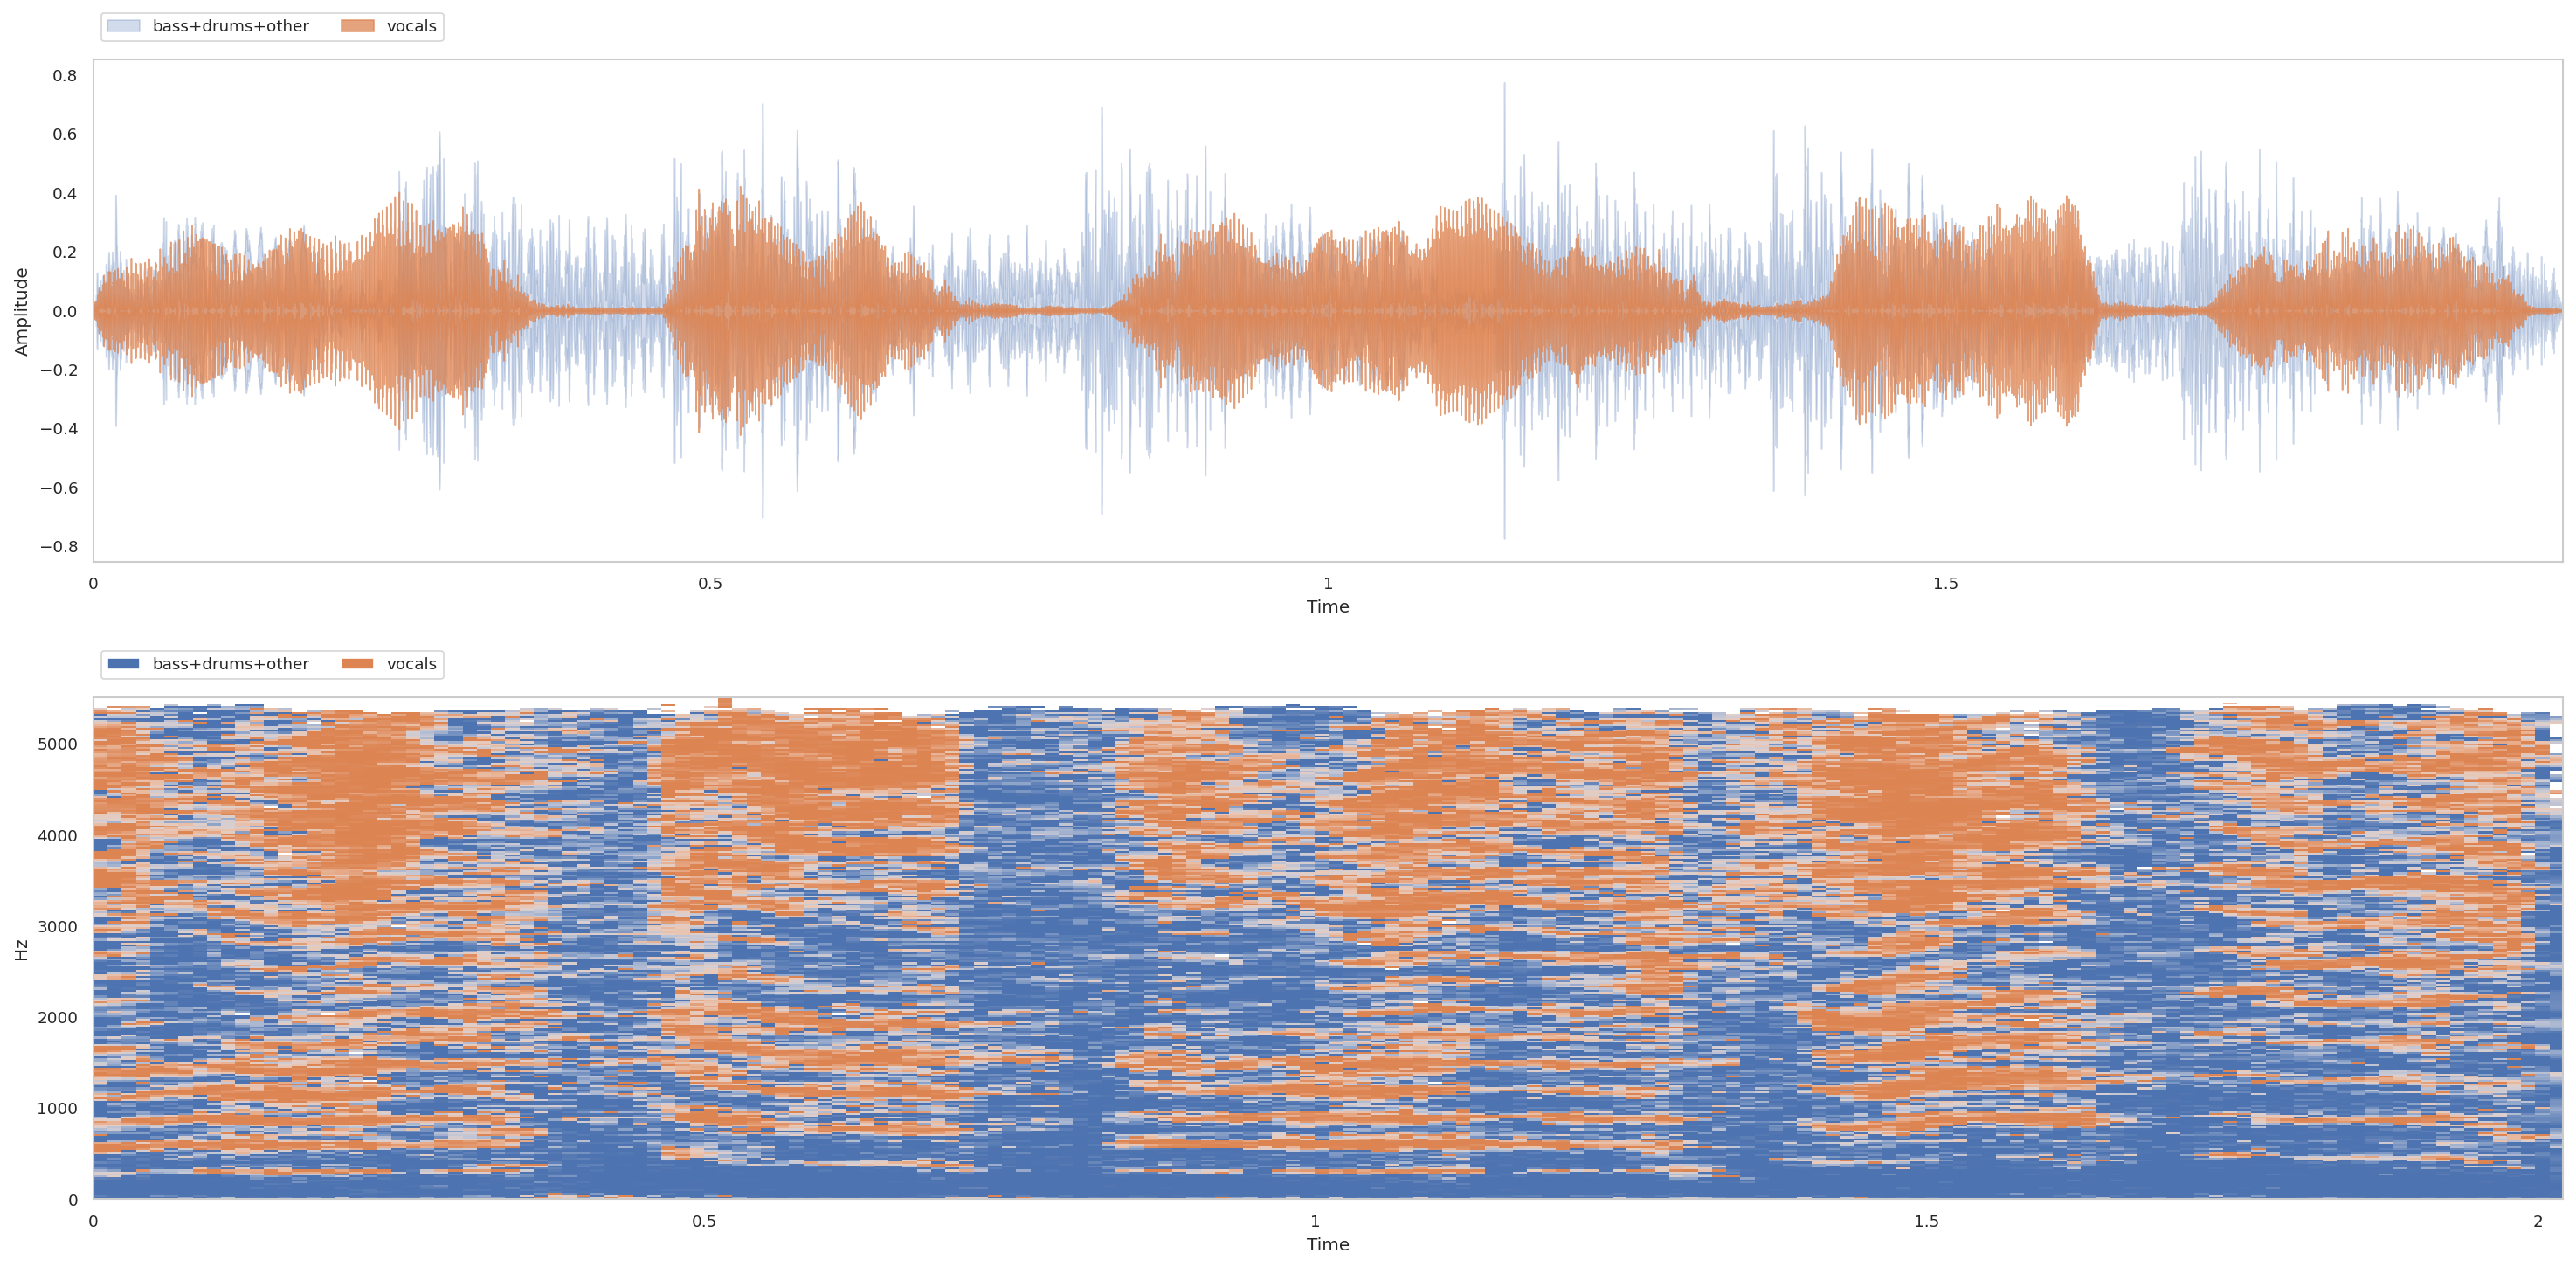


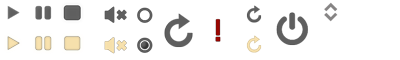
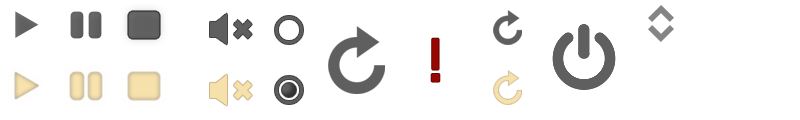
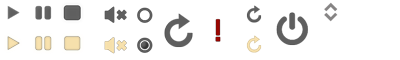

In [ ]:
# Ground Truth
idx = 2
test_song = test_data[idx]
viz.show_sources(test_song['sources'])

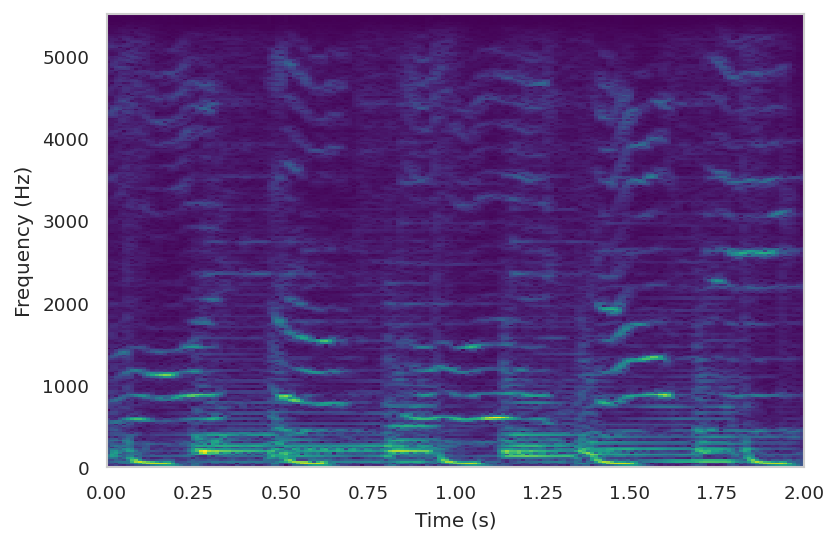

In [ ]:
plt.pcolor(hops_list,frqs_list,pre_process(to_tensor(test_song['mix_magnitude'][:,:,0])))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
save_fp = f'/media/ex_{experiment_name}_input.png'
plt.savefig(save_fp,format='png')
plt.show()

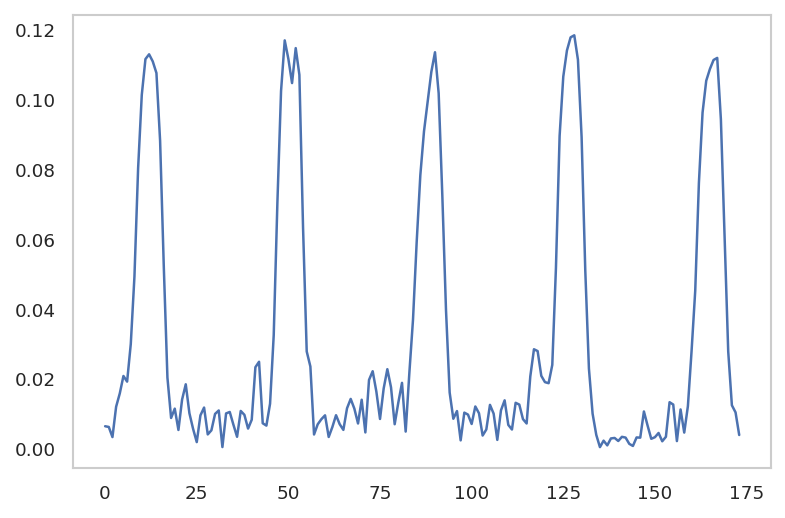

In [ ]:
full_mixture = test_song['mix_magnitude'][:,:,0]
plt.plot(full_mixture[2,:])

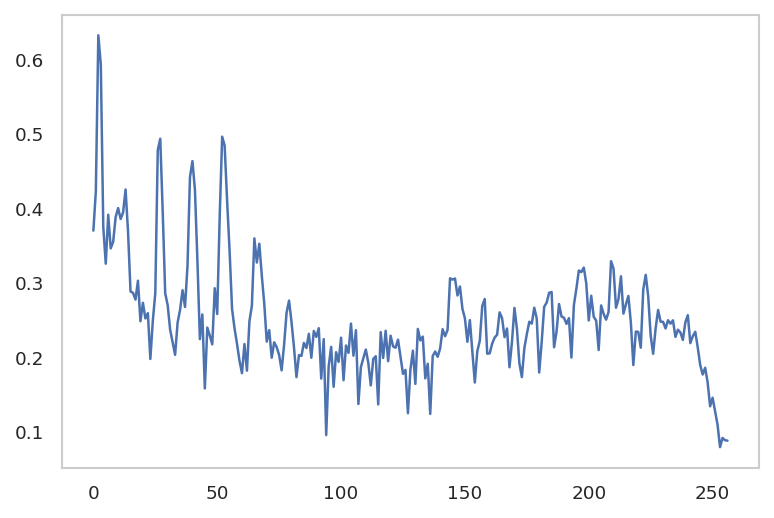

In [ ]:
plt.plot((full_mixture[:,10])**.2)

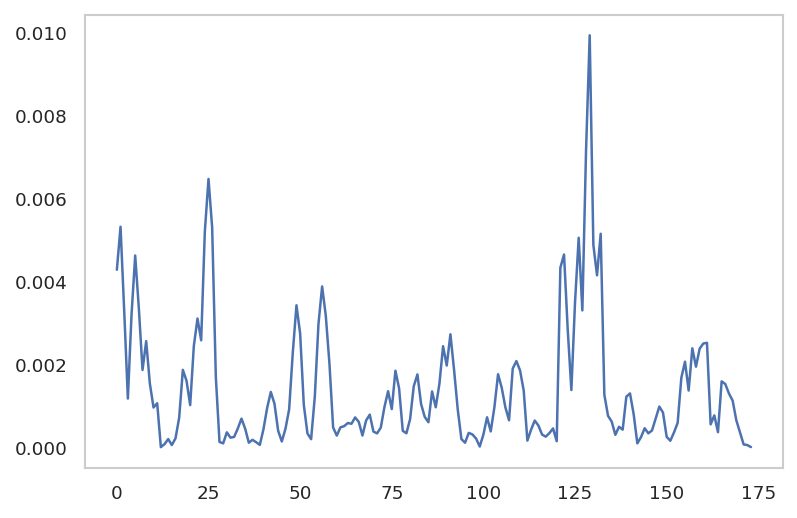

In [ ]:
plt.plot(full_mixture[200,:])

In [ ]:
inputs = to_tensor(test_song['mix_magnitude']).unsqueeze(0).double()
inputs = inputs.permute(0, 3, 1, 2) # permute from nussl's (pre tensor) format of [batches, frequency, time, channels]
                                    #                        to torch's format of [batches, channels, frequency, time]
outputs = to_tensor(test_song['source_magnitudes']).unsqueeze(0).double()
outputs = outputs.permute(0, 3, 1, 2, 4)
outputs_vocals = outputs[:,:,:,:,1]
outputs_accomp = outputs[:,:,:,:,0]

ideal_vocal_mask  = np.clip(outputs_vocals / (inputs + eps),eps,1) #Need clip since the model can only learn mask values between 0 and 1
ideal_accomp_mask = np.clip(outputs_accomp / (inputs + eps),eps,1)

inputs = pre_process(inputs)
outputs_vocals = ideal_vocal_mask  * inputs #pre_process(outputs_vocals)
outputs_accomp = ideal_accomp_mask * inputs #pre_process(outputs_accomp)

y_pred_vocals_masks, y_pred_accomp_masks = model_final(inputs) #feedforward
y_pred_vocals = y_pred_vocals_masks*inputs #apply masks
y_pred_accomp = y_pred_accomp_masks*inputs

loss_vocals = criterion(y_pred_vocals,outputs_vocals)
loss_accomp = criterion(y_pred_accomp,outputs_accomp)
loss = loss_f(loss_vocals,loss_accomp)
print('Validate')
print(f'Vocals Loss: {loss_vocals:.2%}')
print(f'Accomp Loss: {loss_accomp:.2%}')
print('')

#remove batch and channel dimentions
masks_and_sources = [y_pred_vocals_masks,y_pred_accomp_masks,y_pred_vocals,y_pred_accomp]
y_pred_vocals_masks,y_pred_accomp_masks,y_pred_vocals,y_pred_accomp = map(lambda x: to_numpy(x).squeeze(0).squeeze(0), masks_and_sources)

Validate
Vocals Loss: 32.80%
Accomp Loss: 15.44%



In [ ]:
#ensure the range is within [0,1], and there are values close to either end
print(f'Mask Range: [{np.min(y_pred_vocals_masks):.3f}, {np.max(y_pred_vocals_masks):.3f}]') #TODO make a function that shows histogram of values

Mask Range: [0.002, 0.992]


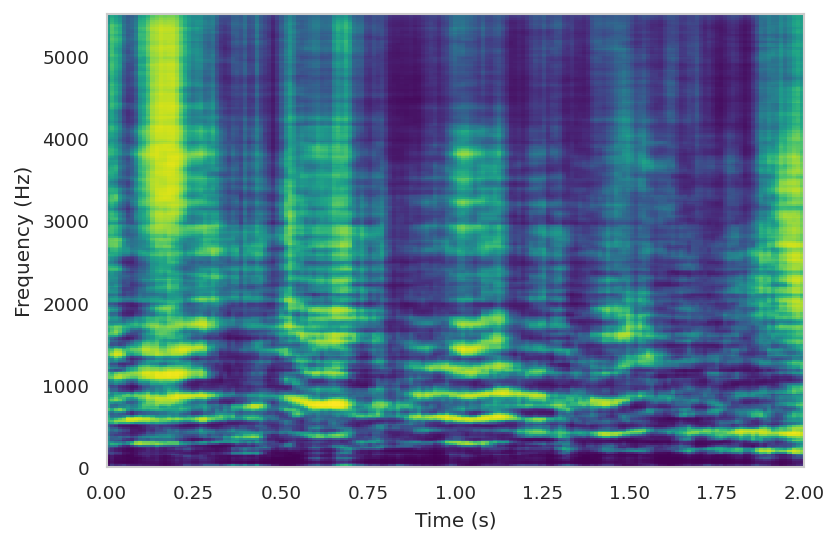

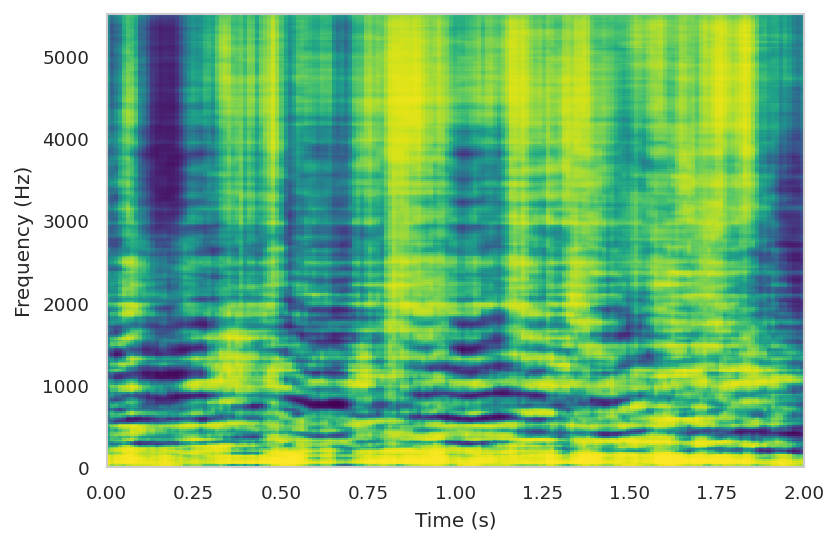

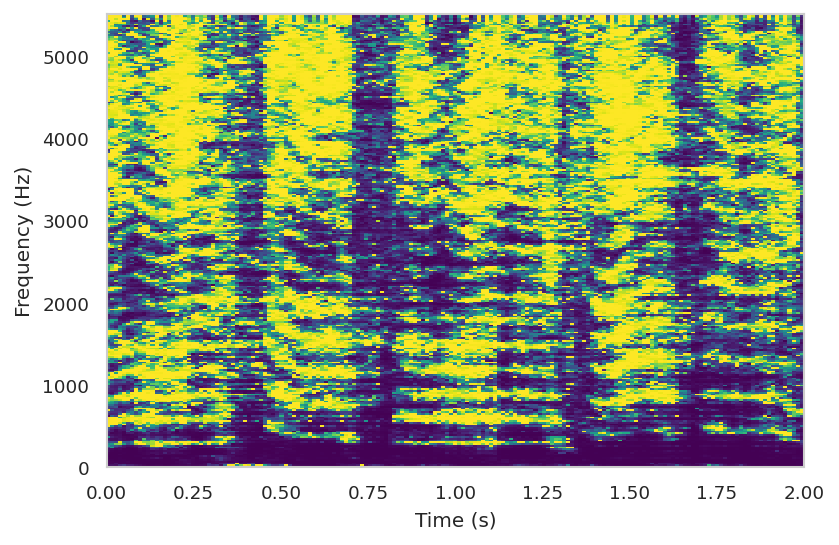

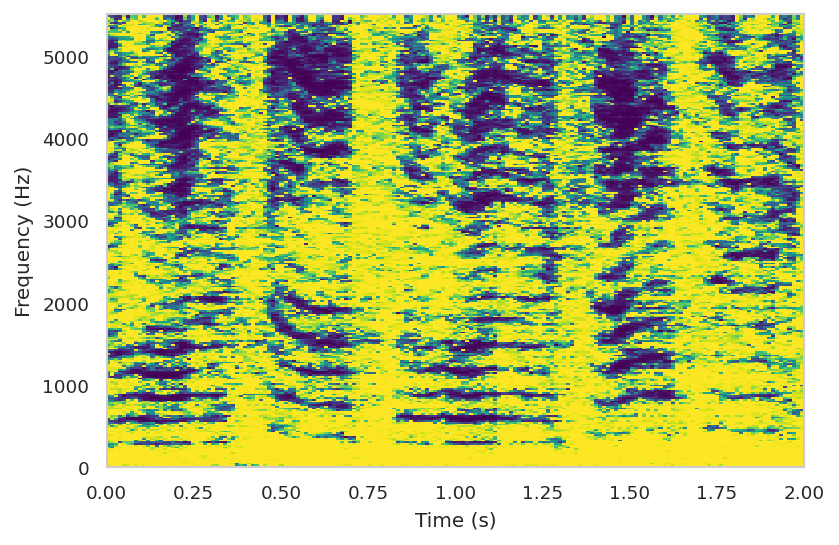

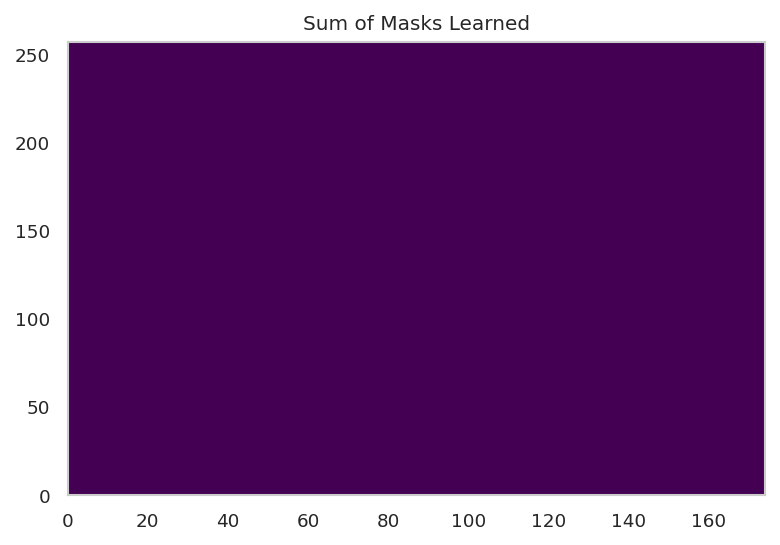

In [ ]:
##---Masks Learned---#
for idx,(source, mask) in enumerate(zip(['vocal','accomp'],[y_pred_vocals_masks,y_pred_accomp_masks])):
    plt.figure(idx)
    #plt.pcolor(np.log(np.abs((y_test_pred_masks[0][idx*D_in:(idx+1)*D_in]).reshape(n_hops,n_frqs).transpose())))
    #plt.pcolor(to_numpy(log_spectrogram(to_tensor(mask))))
    plt.pcolor(hops_list,frqs_list,mask)
    #plt.title(f'{source} Mask Learned')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    save_fp = f'/media/ex_{experiment_name}_{source}_mask_learned.png'
    plt.savefig(save_fp,format='png')
    plt.show()

eps = 1e-8

ideal_vocal_mask = outputs_vocals[0][0] / (inputs[0][0] + eps)#np.clip(,eps,1)
ideal_accomp_mask = outputs_accomp[0][0] / (inputs[0][0] + eps)#np.clip(,eps,1)

for idx,(source, ideal_mask) in enumerate(zip(['vocal','accomp'],[ideal_vocal_mask,ideal_accomp_mask])):
    plt.figure(idx)
    #plt.pcolor(np.log(np.abs((y_test_pred_masks[0][idx*D_in:(idx+1)*D_in]).reshape(n_hops,n_frqs).transpose())))
    #plt.pcolor(to_numpy(log_spectrogram(to_tensor(mask))))
    plt.pcolor(hops_list,frqs_list,ideal_mask)
    #plt.title(f'Ideal {source} Mask')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    save_fp = f'/media/ex_{experiment_name}_{source}_mask_ideal.png'
    plt.savefig(save_fp,format='png')
    plt.show()

# Ensure the sum of masks is equal to 1
plt.figure(idx+1)
plt.pcolor(to_numpy(log_spectrogram(to_tensor(y_pred_vocals_masks+y_pred_accomp_masks)) ))
plt.title(f'Sum of Masks Learned')
plt.show()

# New Section

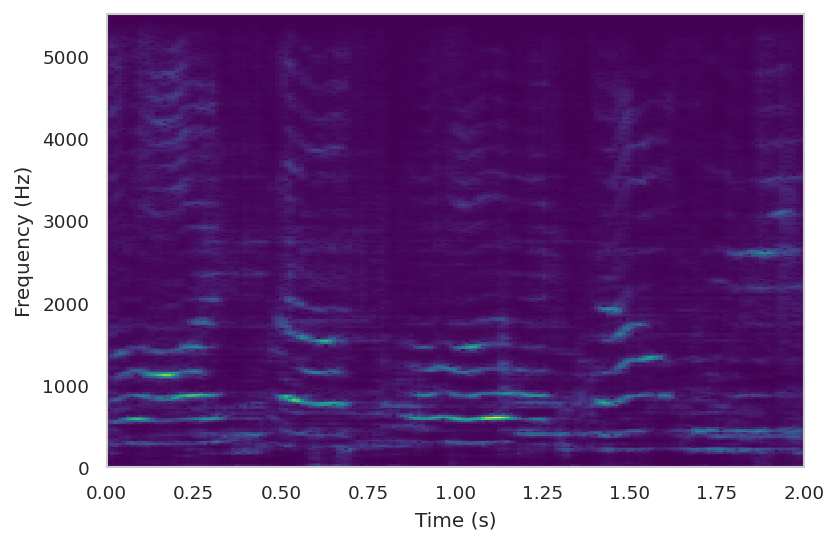

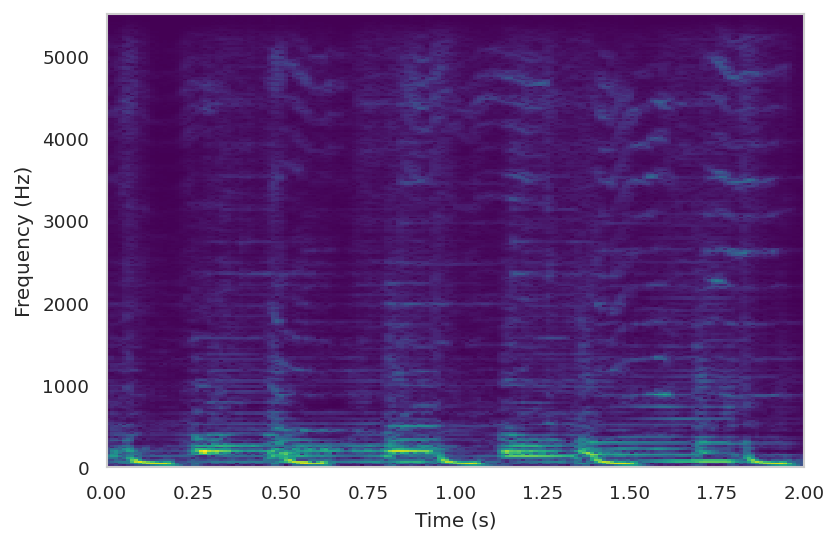

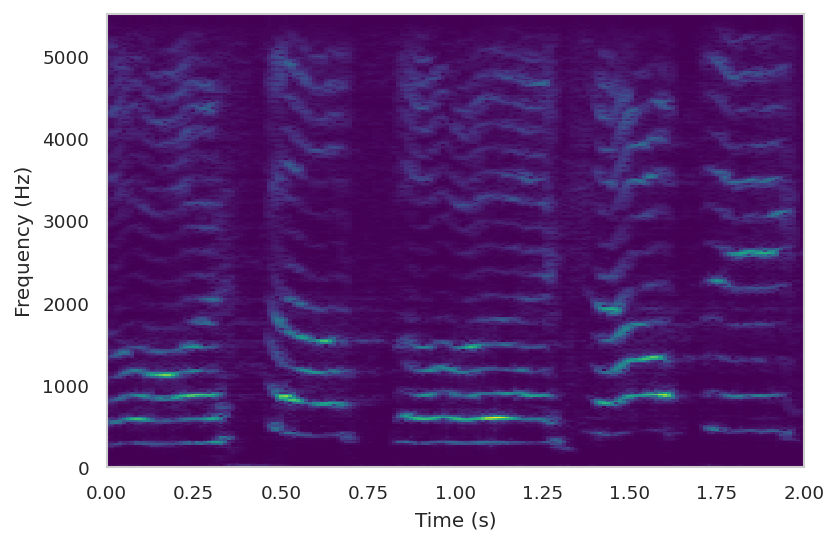

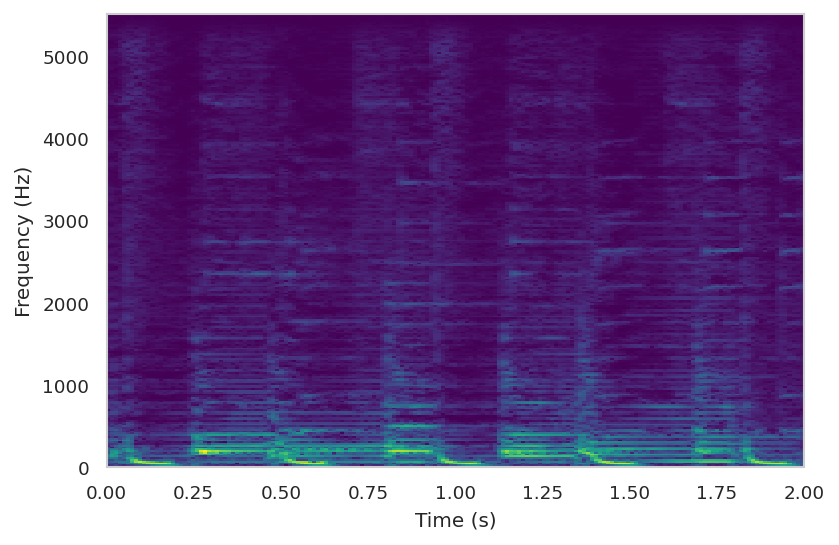

In [ ]:
##---Sources Learned---#
for idx,(source, sourse_STFT) in enumerate(zip(['vocal','accomp'],[y_pred_vocals,y_pred_accomp])):
    plt.figure(idx)
    #plt.pcolor(np.log(np.abs((y_test_pred_masks[0][idx*D_in:(idx+1)*D_in]).reshape(n_hops,n_frqs).transpose())))
    #plt.pcolor(to_numpy(log_spectrogram(to_tensor(mask))))
    plt.pcolor(hops_list,frqs_list,sourse_STFT )
    #plt.title(f'{source} Learned')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    save_fp = f'/media/ex_{experiment_name}_{source}_learned.png'
    plt.savefig(save_fp,format='png')
    plt.show()

for idx,(source, sourse_STFT) in enumerate(zip(['vocal','accomp'],[outputs_vocals[0][0],outputs_accomp[0][0]])):
    plt.figure(idx)
    #plt.pcolor(np.log(np.abs((y_test_pred_masks[0][idx*D_in:(idx+1)*D_in]).reshape(n_hops,n_frqs).transpose())))
    #plt.pcolor(to_numpy(log_spectrogram(to_tensor(mask))))
    plt.pcolor(hops_list,frqs_list,sourse_STFT)
    #plt.title(f'Ground Truth {source}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    save_fp = f'/media/ex_{experiment_name}_{source}_ideal.png'
    plt.savefig(save_fp,format='png')
    plt.show()

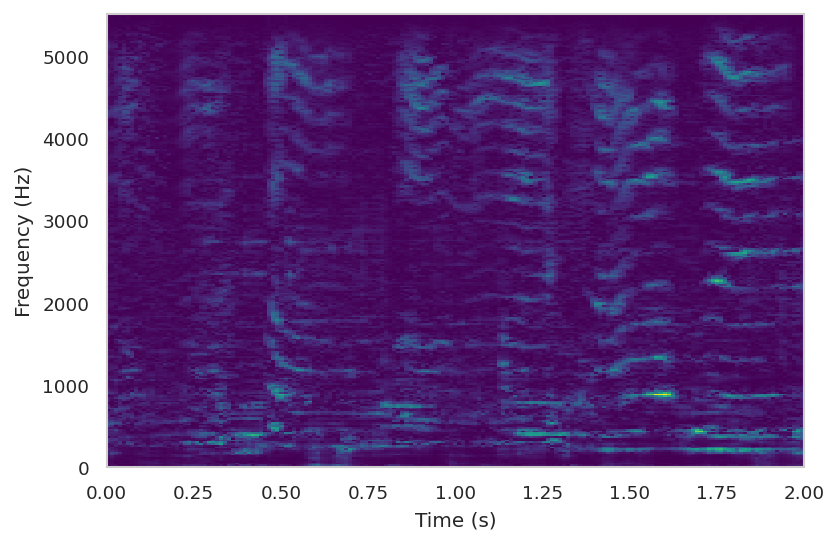

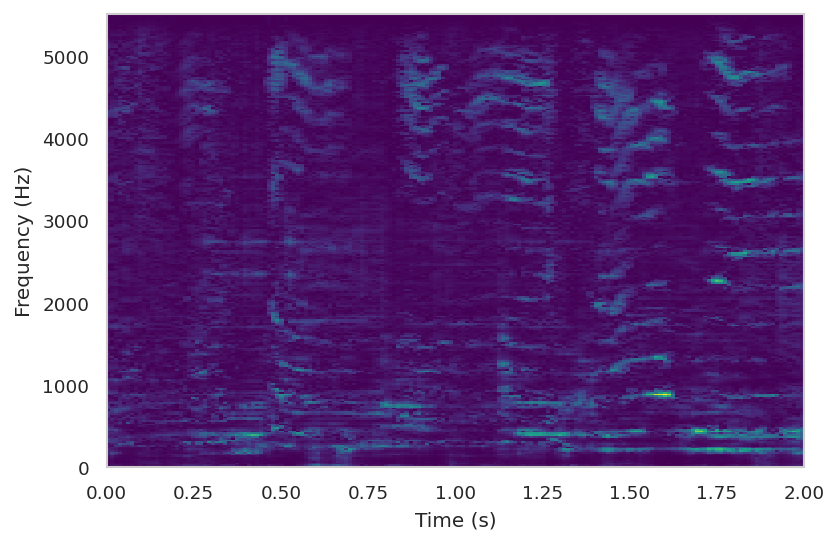

In [ ]:
##---Difference Plots---#
for idx,(source, learned_STFT, true_STFT) in enumerate(zip(['vocal','accomp'],[y_pred_vocals,y_pred_accomp],[outputs_vocals[0][0],outputs_accomp[0][0]])):
    plt.figure(idx)
    plt.pcolor(hops_list, frqs_list, np.abs(learned_STFT - to_numpy(true_STFT)))
    #plt.title(f'{source} Learned')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    save_fp = f'/media/ex_{experiment_name}_{source}_difference.png'
    plt.savefig(save_fp,format='png')
    plt.show()

In [ ]:
# --- Save Files to Collab and Download --- #
download_images = False
if download_images:
    !zip -r /content/all_figs.zip /media
    from google.colab import files
    files.download("/content/all_figs.zip")

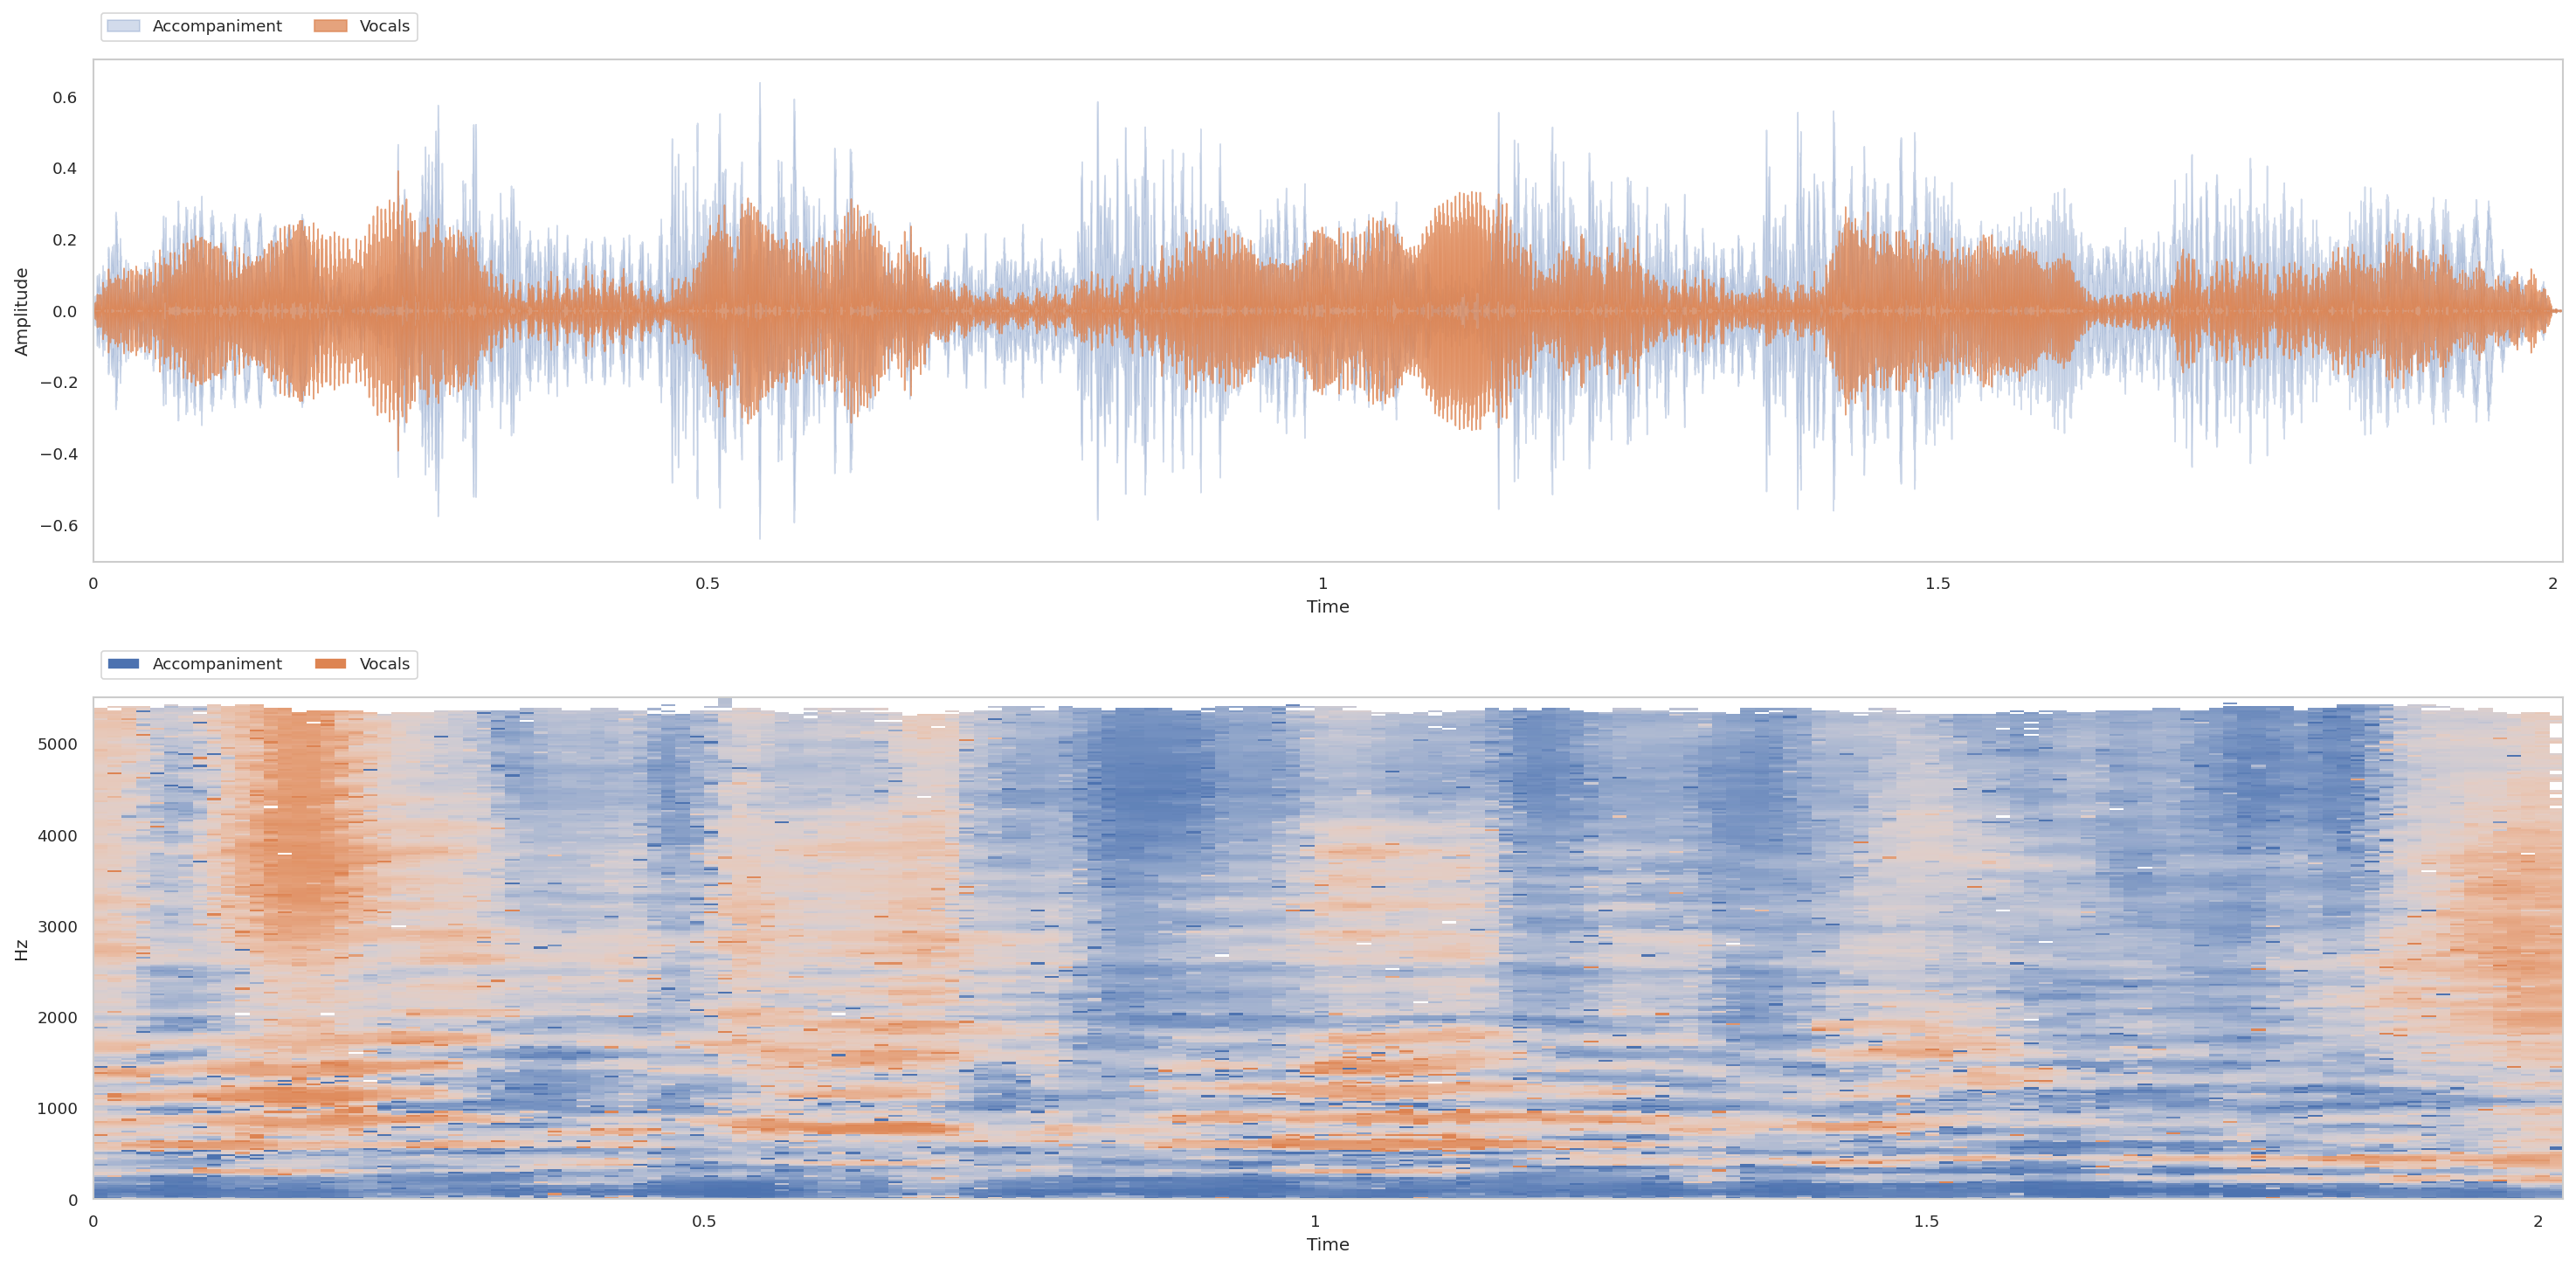


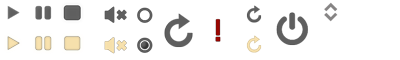
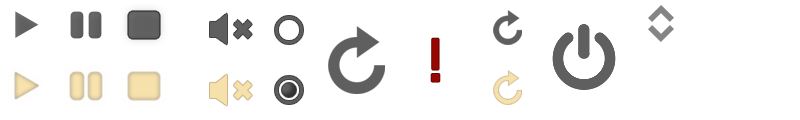
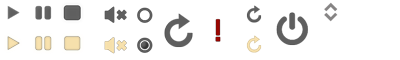

In [ ]:
import collections
# Predicted
input_STFT = test_song['mix'].stft_data # has shape [frequency, time, channels]

predicted_sources = collections.OrderedDict()
for idx,(source, mask) in enumerate(zip(['Vocals','Accompaniment'],[y_pred_vocals_masks,y_pred_accomp_masks])):
    # transpose mask and unsqueeze to go from [frequency, time] to [time, frequency, channels]
    y_predicted_source = np.expand_dims(mask,2) * input_STFT
    source_AudioSignal = nussl.AudioSignal(stft=y_predicted_source,stft_params=stft_params,sample_rate=sample_rate)
    source_AudioSignal.istft(window_length=window_length, hop_length = hop_length, window_type=window_type)
    predicted_sources[source] = source_AudioSignal

viz.show_sources(predicted_sources)

In [ ]:
for idx,(source, sourse_STFT) in enumerate(zip(['Vocals','Accompaniment'],[outputs_vocals[0][0],outputs_accomp[0][0]])):
    plt.figure(idx)
    #plt.pcolor(np.log(np.abs((y_test_pred_masks[0][idx*D_in:(idx+1)*D_in]).reshape(n_hops,n_frqs).transpose())))
    #plt.pcolor(to_numpy(log_spectrogram(to_tensor(mask))))
    plt.pcolor(sourse_STFT* to_numpy(avg_val_per_frq.view(-1,1)))
    plt.title(f'Ground Truth {source}')
    plt.show()

In [ ]:
import collections
# Predicted
input_STFT = test_song['mix'].stft_data # has shape [frequency, time, channels]

predicted_sources = collections.OrderedDict()
for idx,(source, mask) in enumerate(zip(['Vocals','Accompaniment'],[ideal_vocal_mask,ideal_accomp_mask])):
    # transpose mask and unsqueeze to go from [frequency, time] to [time, frequency, channels]
    y_predicted_source = np.expand_dims(mask,2) * input_STFT
    source_AudioSignal = nussl.AudioSignal(stft=y_predicted_source,stft_params=stft_params,sample_rate=sample_rate)
    source_AudioSignal.istft(window_length=window_length, hop_length = hop_length, window_type=window_type)
    predicted_sources[source] = source_AudioSignal

viz.show_sources(predicted_sources)

"testing" on train data

In [ ]:
#TODO preprocess all inputs/outputs with these operations
# Unpack data
inputs         = train_batch[0:1,0,:,:,:].to('cpu')
outputs_vocals = train_batch[0:1,1,:,:,:].to('cpu')
outputs_accomp = train_batch[0:1,2,:,:,:].to('cpu')

y_pred1_vocals_masks, y_pred1_accomp_masks = model_final(inputs) #feedforward
y_pred1_vocals = y_pred1_vocals_masks*inputs #apply masks
y_pred1_accomp = y_pred1_accomp_masks*inputs

loss_vocals = criterion(y_pred1_vocals,outputs_vocals)
loss_accomp = criterion(y_pred1_accomp,outputs_accomp)
loss1 = loss_f(loss_vocals,loss_accomp)
train_part1_loss[iteration_num] = loss1

print(f'Training')
print(f'Vocals Loss: {loss_vocals:.2%}')
print(f'Accomp Loss: {loss_accomp:.2%}')
print(f'Weighted Loss: {loss1:.2%}')
print('')

#remove batch and channel dimentions
masks_and_sources = [y_pred1_vocals_masks,y_pred1_accomp_masks,y_pred1_vocals,y_pred1_accomp]
y_pred_vocals_masks,y_pred_accomp_masks,y_pred_vocals,y_pred_accomp = map(lambda x: to_numpy(x[0]).squeeze(0), masks_and_sources)

In [ ]:
##---Masks Learned---#
for idx,(source, mask) in enumerate(zip(['Vocals','Accompaniment'],[y_pred_vocals_masks,y_pred_accomp_masks])):
    plt.figure(idx)
    #plt.pcolor(np.log(np.abs((y_test_pred_masks[0][idx*D_in:(idx+1)*D_in]).reshape(n_hops,n_frqs).transpose())))
    #plt.pcolor(to_numpy(log_spectrogram(to_tensor(mask))))
    plt.pcolor(mask)
    plt.title(f'{source} Mask Learned')
    plt.show()

eps = 1e-5

ideal_vocal_mask = np.clip(outputs_vocals[0][0] / (inputs[0][0] + eps),eps,1)
ideal_accomp_mask = np.clip(outputs_accomp[0][0] / (inputs[0][0] + eps),eps,1)

for idx,(source, ideal_mask) in enumerate(zip(['Vocals','Accompaniment'],[ideal_vocal_mask,ideal_accomp_mask])):
    plt.figure(idx)
    #plt.pcolor(np.log(np.abs((y_test_pred_masks[0][idx*D_in:(idx+1)*D_in]).reshape(n_hops,n_frqs).transpose())))
    #plt.pcolor(to_numpy(log_spectrogram(to_tensor(mask))))
    plt.pcolor(ideal_mask)
    plt.title(f'Ideal {source} Mask')
    plt.show()

# Ensure the sum of masks is equal to 1
plt.figure(idx+1)
plt.pcolor(to_numpy(log_spectrogram(to_tensor(y_pred_vocals_masks+y_pred_accomp_masks)) ))
plt.title(f'Sum of Masks Learned')
plt.show()

In [ ]:
##---Sources Learned---#
for idx,(source, sourse_STFT) in enumerate(zip(['Vocals','Accompaniment'],[y_pred_vocals,y_pred_accomp])):
    plt.figure(idx)
    #plt.pcolor(np.log(np.abs((y_test_pred_masks[0][idx*D_in:(idx+1)*D_in]).reshape(n_hops,n_frqs).transpose())))
    #plt.pcolor(to_numpy(log_spectrogram(to_tensor(mask))))
    plt.pcolor(sourse_STFT )
    plt.title(f'{source} Learned')
    plt.show()

for idx,(source, sourse_STFT) in enumerate(zip(['Vocals','Accompaniment'],[outputs_vocals[0][0],outputs_accomp[0][0]])):
    plt.figure(idx)
    #plt.pcolor(np.log(np.abs((y_test_pred_masks[0][idx*D_in:(idx+1)*D_in]).reshape(n_hops,n_frqs).transpose())))
    #plt.pcolor(to_numpy(log_spectrogram(to_tensor(mask))))
    plt.pcolor(sourse_STFT)
    plt.title(f'Ground Truth {source}')
    plt.show()

In [ ]:
# Predicted
predicted_sources = collections.OrderedDict()
for idx,(source, pred_source) in enumerate(zip(['Vocals','Accompaniment'],[y_pred_vocals,y_pred_accomp])):
    # transpose mask and unsqueeze to go from [frequency, time] to [time, frequency, channels]
    y_predicted_source = pred_source
    source_AudioSignal = nussl.AudioSignal(stft=y_predicted_source,stft_params=stft_params,sample_rate=sample_rate)
    source_AudioSignal.istft(window_length=window_length, hop_length = hop_length, window_type=window_type)
    predicted_sources[source] = source_AudioSignal

viz.show_sources(predicted_sources)

In [ ]:
# Create separator object
separator = nussl.separation.deep.DeepMaskEstimation(
    nussl.AudioSignal(), model_path='checkpoints/best.model.pth',
    device=device,
)

In [ ]:
##--- Full Evaluation of Model ---##

import json

tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
])
test_dataset = nussl.datasets.MUSDB18(subsets=['test'], transform=tfm)

# Just do 5 items for speed. Change to 50 for actual experiment.
for i, item in enumerate(test_dataset[:5]):
    separator.audio_signal = item['mix']
    estimates = separator()

    source_keys = list(item['sources'].keys())
    estimates = {
        'vocals': estimates[0],
        'bass+drums+other': item['mix'] - estimates[0]
    }

    sources = [item['sources'][k] for k in source_keys]
    estimates = [estimates[k] for k in source_keys]

    evaluator = nussl.evaluation.BSSEvalScale(
        sources, estimates, source_labels=source_keys
    )
    scores = evaluator.evaluate()
    output_folder = Path(output_folder).absolute()
    output_folder.mkdir(exist_ok=True)
    output_file = output_folder / sources[0].file_name.replace('wav', 'json')
    with open(output_file, 'w') as f:
        json.dump(scores, f, indent=4)